In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize, LogNorm, PowerNorm
import cv2
import PIL
from IPython.display import Image

from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import resize
import matplotlib.pyplot as plt

In [249]:
!gdown https://drive.google.com/uc?id=1lJKLz3LsQmnAf9q5GGi6arEYBz-3CMhx -O 20240507.rar
!mkdir -p ./20240507_cut_npy
!unrar x 20240507.rar ./20240507_cut_npy
!rm 20240507.rar

'gdown' is not recognized as an internal or external command,
operable program or batch file.
The syntax of the command is incorrect.
'unrar' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


# **0. Helpers**

In [2]:
def imshow(a):
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

In [3]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

In [10]:
def get_time_interval(files, start, end):
    """
    Retrieves and concatenates data from a specified time interval based on file names.

    Parameters:
    ----------
    files : list of str
        A list of file paths, where each file contains data for a specific time interval.
    start : str
        The starting time of the interval in the format "HHMMSS" (e.g., "090000" for 9:00:00).
    end : str
        The ending time of the interval in the format "HHMMSS" (e.g., "100000" for 10:00:00).

    Returns:
    -------
    tuple
        A tuple containing:
        - ndarray: A concatenated 2D array containing the data from all files in the specified time interval.
        - str: The file path corresponding to the first file in the interval.
    """
    data = []
    first_file = '20240507_cut_npy/' + start + '.npy' #/
    last_file = '20240507_cut_npy/' + end + '.npy' #/
    for file in files:
        if file >= first_file and file <= last_file:
            data.append(np.load(file))

    data = np.concatenate(data)
    return data, first_file

In [11]:
def plotting_function(data, idx, cols, norm=None, cmap = None):
    """
    Visualizes a 2D dataset as a heatmap with labeled axes and a color bar.

    Parameters:
    ----------
    data : ndarray
        The 2D array containing the data to be plotted.
    idx : iterable
        The row index for the data, corresponding to time.
    cols : iterable
        The column index for the data, corresponding to space.
    norm : matplotlib.colors.Normalize, optional
        A normalization instance to scale the colormap. If None, no normalization is applied.

    Returns:
    -------
    None
        The function displays the heatmap and does not return any value.
    """
    df = pd.DataFrame(data, index = idx, columns=cols)

    fig = plt.figure(figsize=(12,16))
    ax = plt.axes()
    
    if norm is not None:
        im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm, cmap = cmap)
    else:
        im = ax.imshow(df,interpolation='none',aspect='auto', cmap = cmap)

    plt.ylabel('time [HH:MM:SS]')
    plt.xlabel('space [m]')

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    x_positions, x_labels = set_axis(cols)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    plt.show()

# def display_gray(data, idx, cols, norm=None):
#     """
#     Visualizes a 2D dataset as a heatmap in a grayscale with labeled axes and a color bar.

#     Parameters:
#     ----------
#     data : ndarray
#         The 2D array containing the data to be plotted.
#     idx : iterable
#         The row index for the data, corresponding to time.
#     cols : iterable
#         The column index for the data, corresponding to space.
#     norm : matplotlib.colors.Normalize, optional
#         A normalization instance to scale the colormap. If None, no normalization is applied.

#     Returns:
#     -------
#     None
#         The function displays the heatmap in a grayscale and does not return any value.
#     """
#     df = pd.DataFrame(data, index = idx, columns=cols)

#     fig = plt.figure(figsize=(12,16))
#     ax = plt.axes()
    
#     if norm is not None:
#         im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm, cmap='gray')
#     else:
#         im = ax.imshow(df,interpolation='none',aspect='auto', cmap='gray')

#     plt.ylabel('time [HH:MM:SS]')
#     plt.xlabel('space [m]')

#     cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
#     plt.colorbar(im, cax=cax)
#     x_positions, x_labels = set_axis(cols)
#     ax.set_xticks(x_positions, np.round(x_labels))
#     y_positions, y_labels = set_axis(df.index.time)
#     ax.set_yticks(y_positions, y_labels)
#     plt.show()

In [12]:
def get_proper_df(data, first_file, dx= 5.106500953873407, dt= 0.0016):
    """
    Converts raw data into a properly indexed and normalized DataFrame.

    Parameters:
    ----------
    data : ndarray
        The raw data to be converted into a DataFrame. This is a 2D array where each row represents a time step, 
        and each column corresponds to a spatial position.
    first_file : str
        The name of the first file used for generating the time index. It should be in the format "YYYYMMDD_HHMMSS.npy".
    dx : float, optional
        The spatial step size, i.e., the distance between consecutive spatial points (default is 5.1065).
    dt : float, optional
        The time step size, i.e., the time interval between consecutive time steps (default is 0.0016 seconds).

    Returns:
    -------
    pd.DataFrame
        A DataFrame with time as the index, spatial positions as columns, and the normalized, absolute values 
        of the original data. The data is also centered around its mean before taking the absolute value.
    """
    time_start = datetime.datetime.strptime('2024-05-07 ' + first_file.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S") #/
    index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')
    columns = np.arange(len(data[0])) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    df -= df.mean()
    df = np.abs(df)

    return df

# **1. Reading data**

In [13]:
path_out = '20240507_cut_npy/'
files = glob.glob(path_out+"*")
files.sort()

In [14]:
data, first_file = get_time_interval(files, '092352', '092542')
df = get_proper_df(data, first_file)

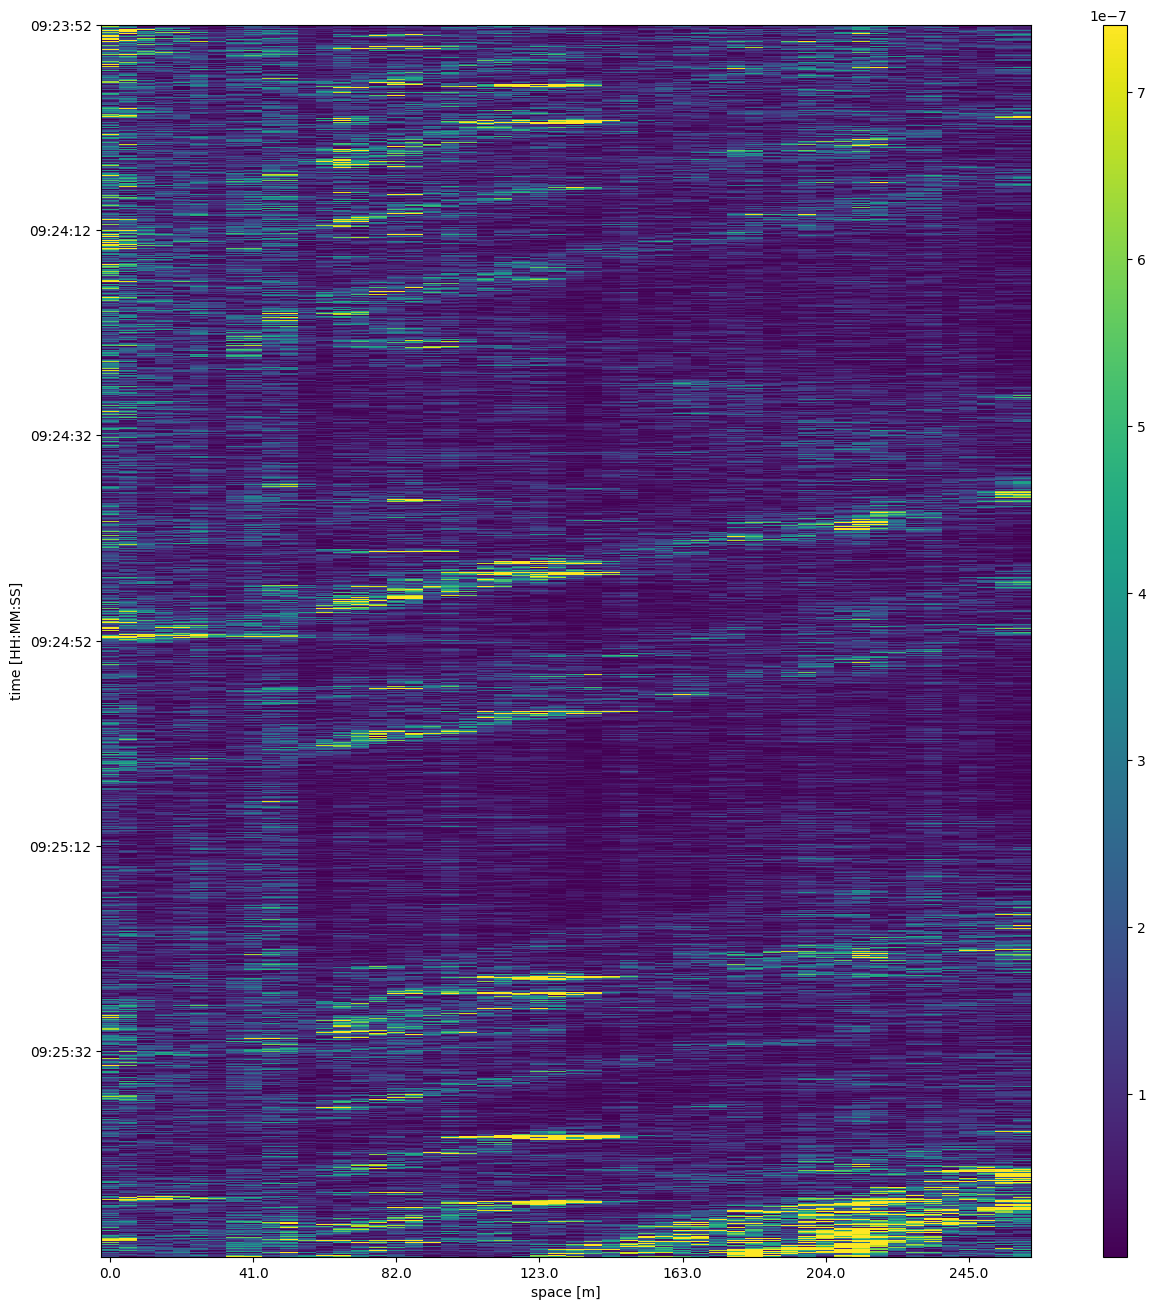

In [15]:
fig = plt.figure(figsize=(12,16))
ax = plt.axes()

low, high = np.percentile(df, [3, 99]) 
norm = Normalize(vmin=low, vmax=high, clip=True)

im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
plt.ylabel('time [HH:MM:SS]')
plt.xlabel('space [m]')

cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)
plt.show()


# **2. Data analysis** #

## **2.1. Basic statistical parameters** ##

In [17]:
np.info(df.values)
print()

print("Min:", np.min(df))
print("Max:", np.max(df))
print("Mean:", np.mean(df))
print("Standard deviation:", np.std(df.values))
print()

print("Percentiles:")
for i in [0, 5, 25, 50, 75, 95, 100]:
    print(f"{i}-th percentile: {np.percentile(df, [i])[0]}")

class:  ndarray
shape:  (75000, 52)
strides:  (208, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x32a29c000
byteorder:  little
byteswap:  False
type: float32

Min: 8.790718e-12
Max: 2.972713e-05
Mean: 1.1305762e-07
Standard deviation: 2.2458845e-07

Percentiles:
0-th percentile: 8.790718153406374e-12
5-th percentile: 4.824732169339541e-09
25-th percentile: 2.8482679326202742e-08
50-th percentile: 6.691173837225506e-08
75-th percentile: 1.3291327150000143e-07
95-th percentile: 3.44083676395712e-07
100-th percentile: 2.9727130822720937e-05


What above shows us is that our data pretty much distributed. Minimum and maximum are far away from each other (10^7 times bigger == 7 orders of magnitude). Thus, we know we will need some sort of min-max scaling to shift them into some meaningful interval (0 - 1 that can be later scaled to 0 - 255). Another important observation is that outliers are very far away, i. e. 5 and 95 percentile are 2 to 3 orders of magnitude away from minimum and maximum and if the dataset is scaled without thinking, then all values will be close to mean which does not make much sense. Also, shape of data is very divergent - we will probably rescale our image so instead of having 75k and 28 values on axes, we will lengths of axes that are closer to each other.

## **2.2. Violin plot** ##

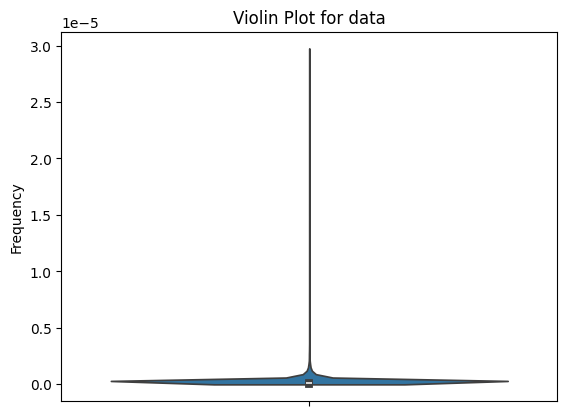

In [21]:
sns.violinplot(data = df.values.flatten())
plt.ylabel("Frequency")
plt.title("Violin Plot for data")
plt.show()

This approach doesn't provide much information. More accurate is to show data between some percentiles (e. g. between 2-nd and 98-th).

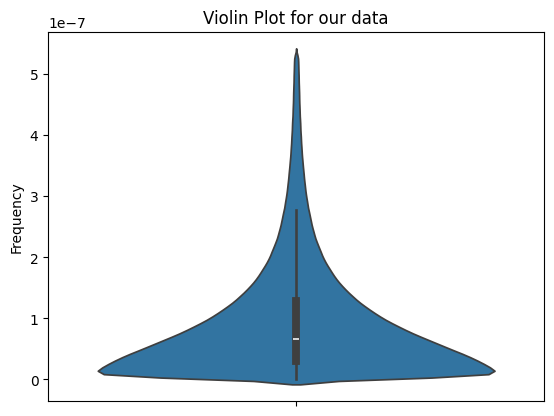

In [22]:
low, high = np.percentile(df.values.flatten(), [2, 98])

sns.violinplot(data = df.values.flatten()[(df.values.flatten() >= low) & (df.values.flatten() <= high)])
plt.ylabel("Frequency")
plt.title("Violin Plot for our data")
plt.show()

Here we can see that most values are located in the lower part of the interval and small number of values exceeds 3 * 10^-7. 

## **2.3. PDF** ##

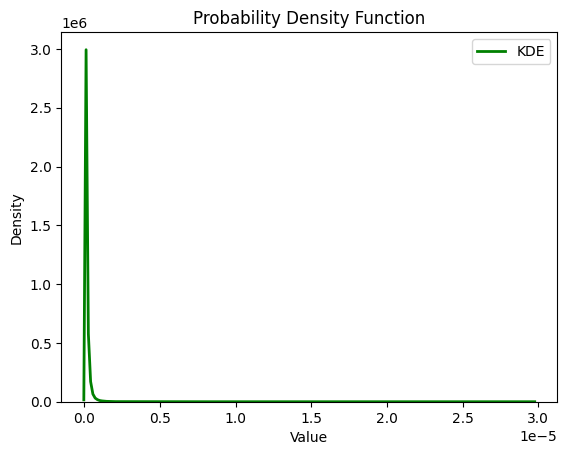

In [23]:
sns.kdeplot(df.values.flatten(), color="green", label="KDE", linewidth=2)
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Probability Density Function")
plt.legend()
plt.show()

## **2.4. Plotting raw data** ##

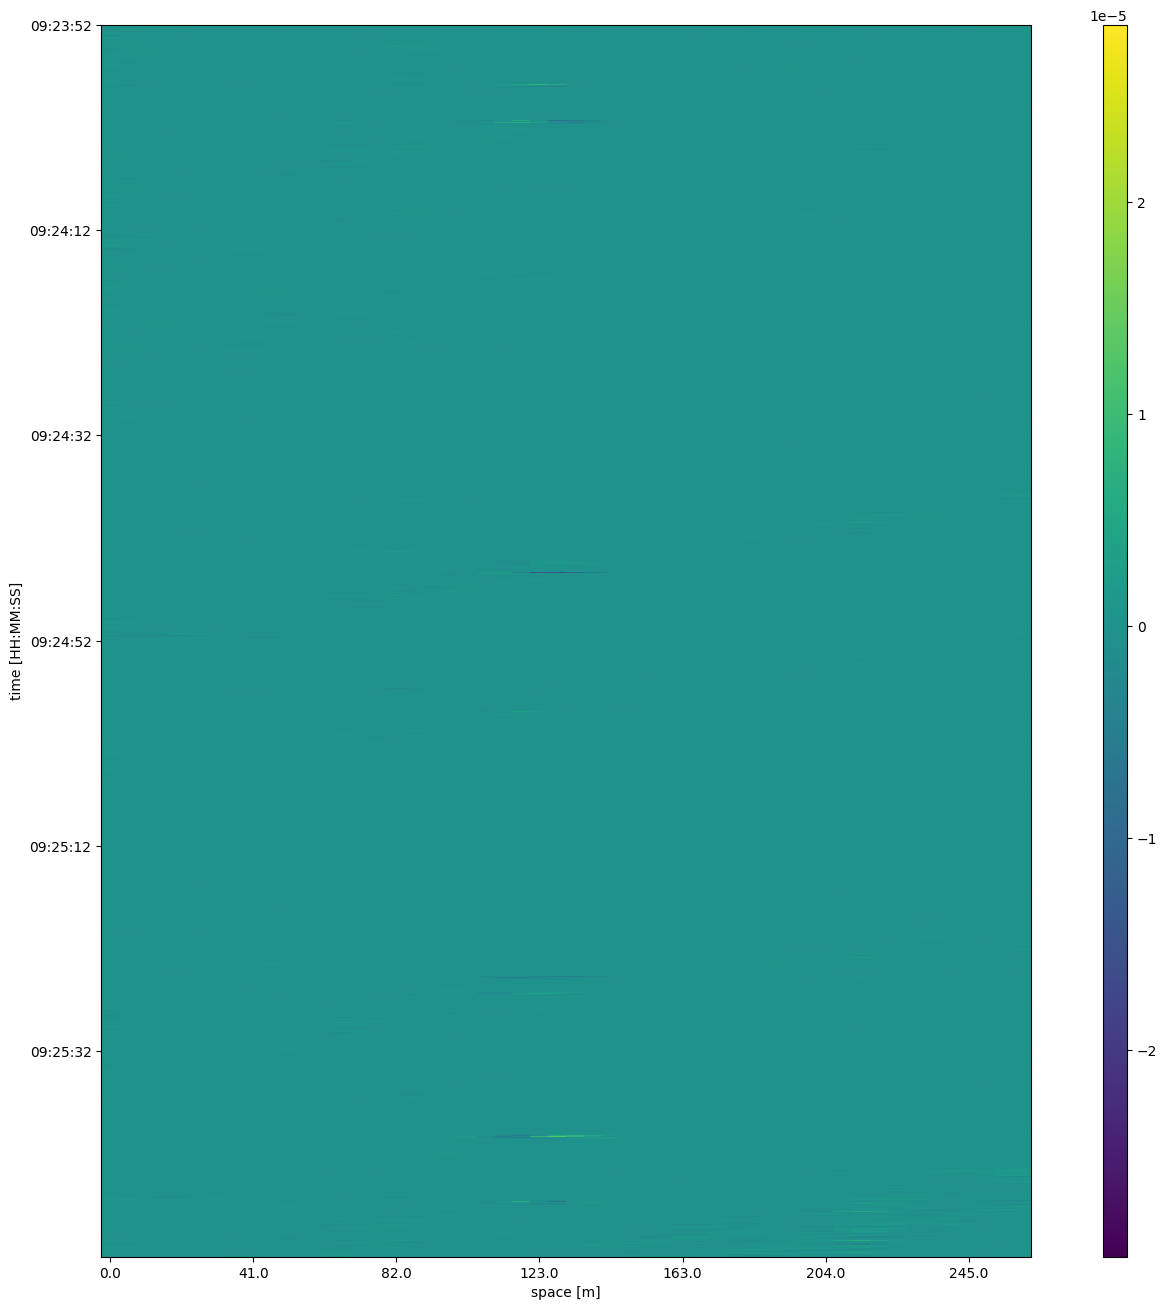

In [25]:
plotting_function(data, df.index, df.columns)

This does not provide a lot of information. And that is as expected - we previously saw that most values are located around the mean and distance between outliers and mean is outstanding. That's why we see this as turquis rectangle.

### **2.5.1. Min-Max normalization** ###

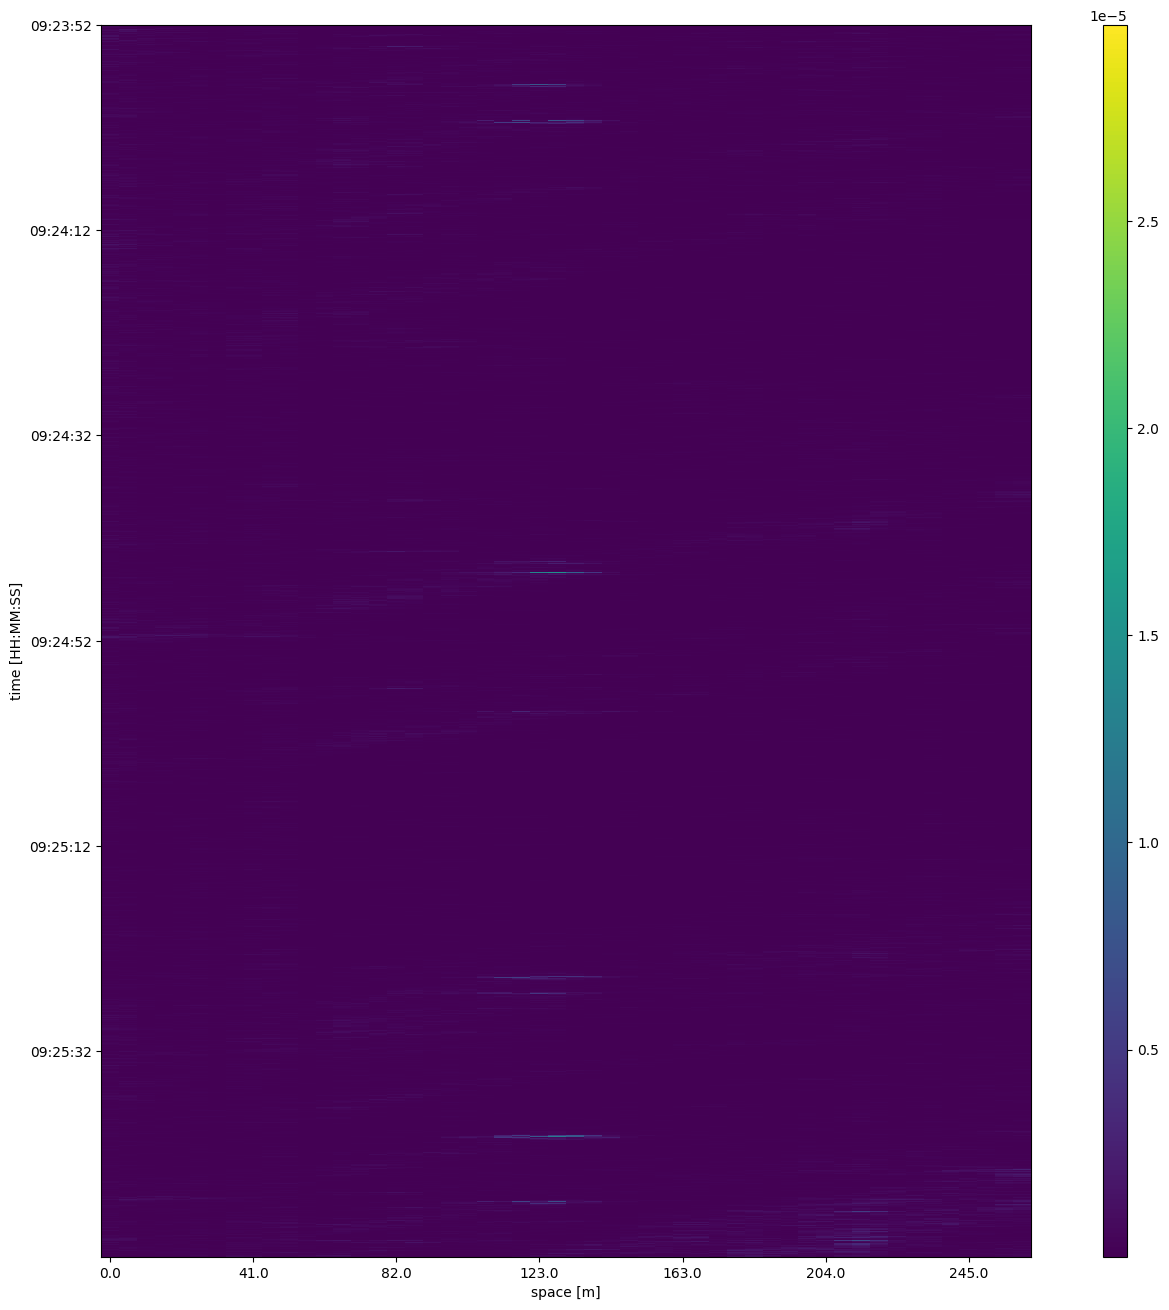

In [26]:
low, high = np.percentile(df, [0, 100]) 
norm = Normalize(vmin=low, vmax=high, clip=True)

plotting_function(abs(df.values), df.index, df.columns, norm)

## **2.5.2. Min-Max Normalization upgraded** ##

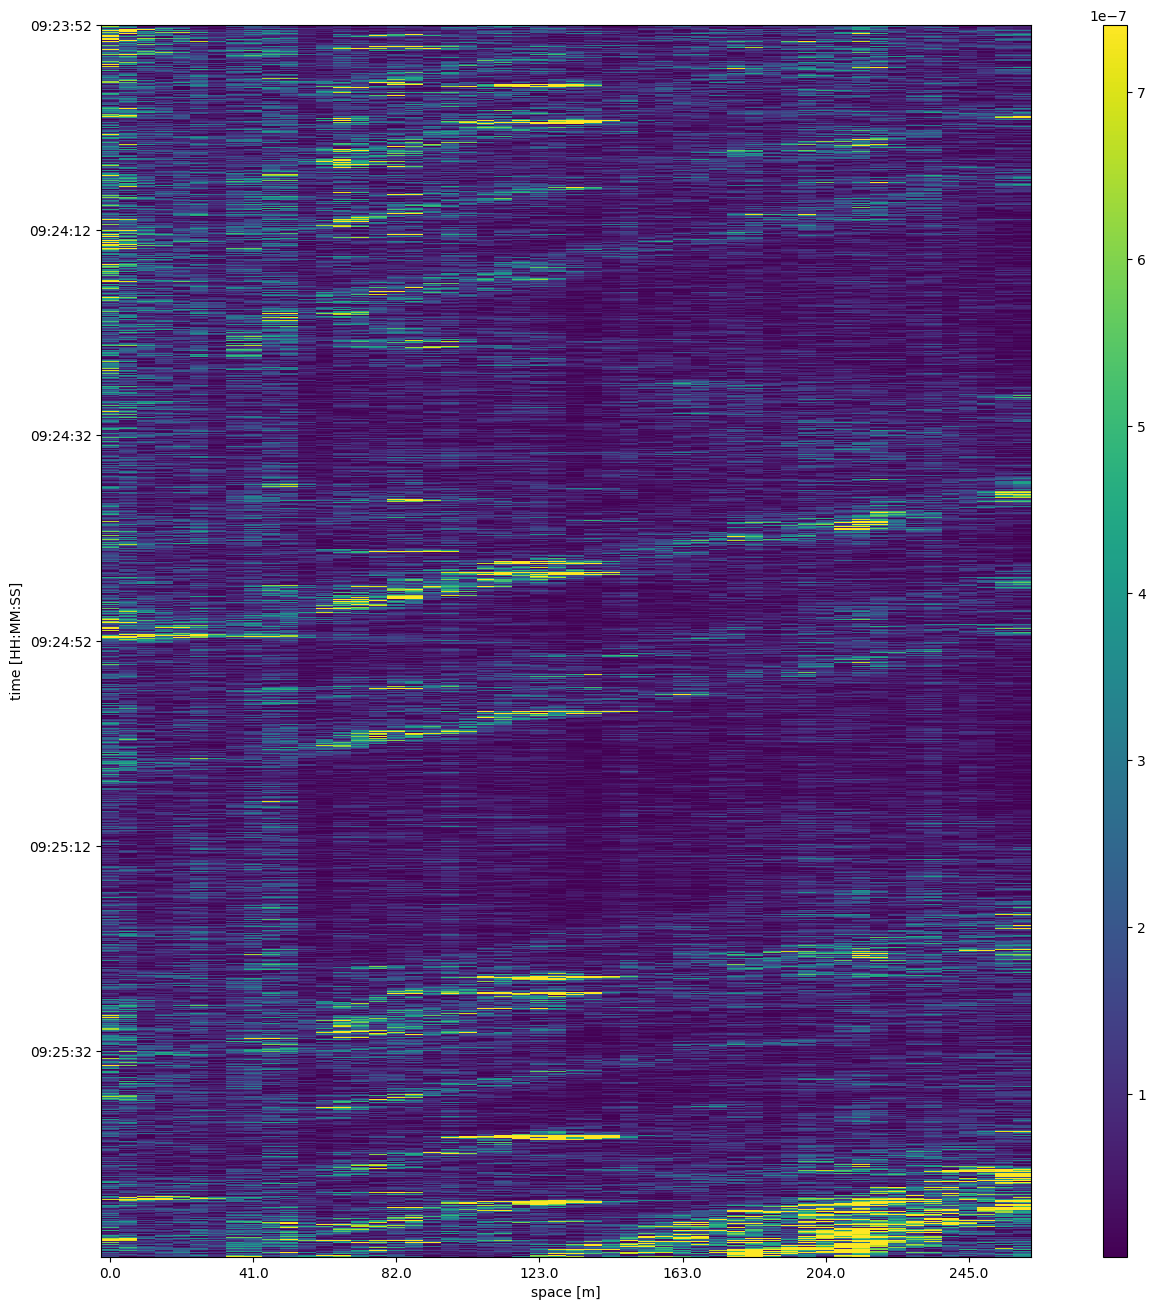

In [27]:
low, high = np.percentile(df, [3, 99]) 
norm_mm = Normalize(vmin=low, vmax=high, clip=True)

plotting_function(abs(df.values), df.index, df.columns, norm_mm)

## **2.5.3. Log scaling** ##

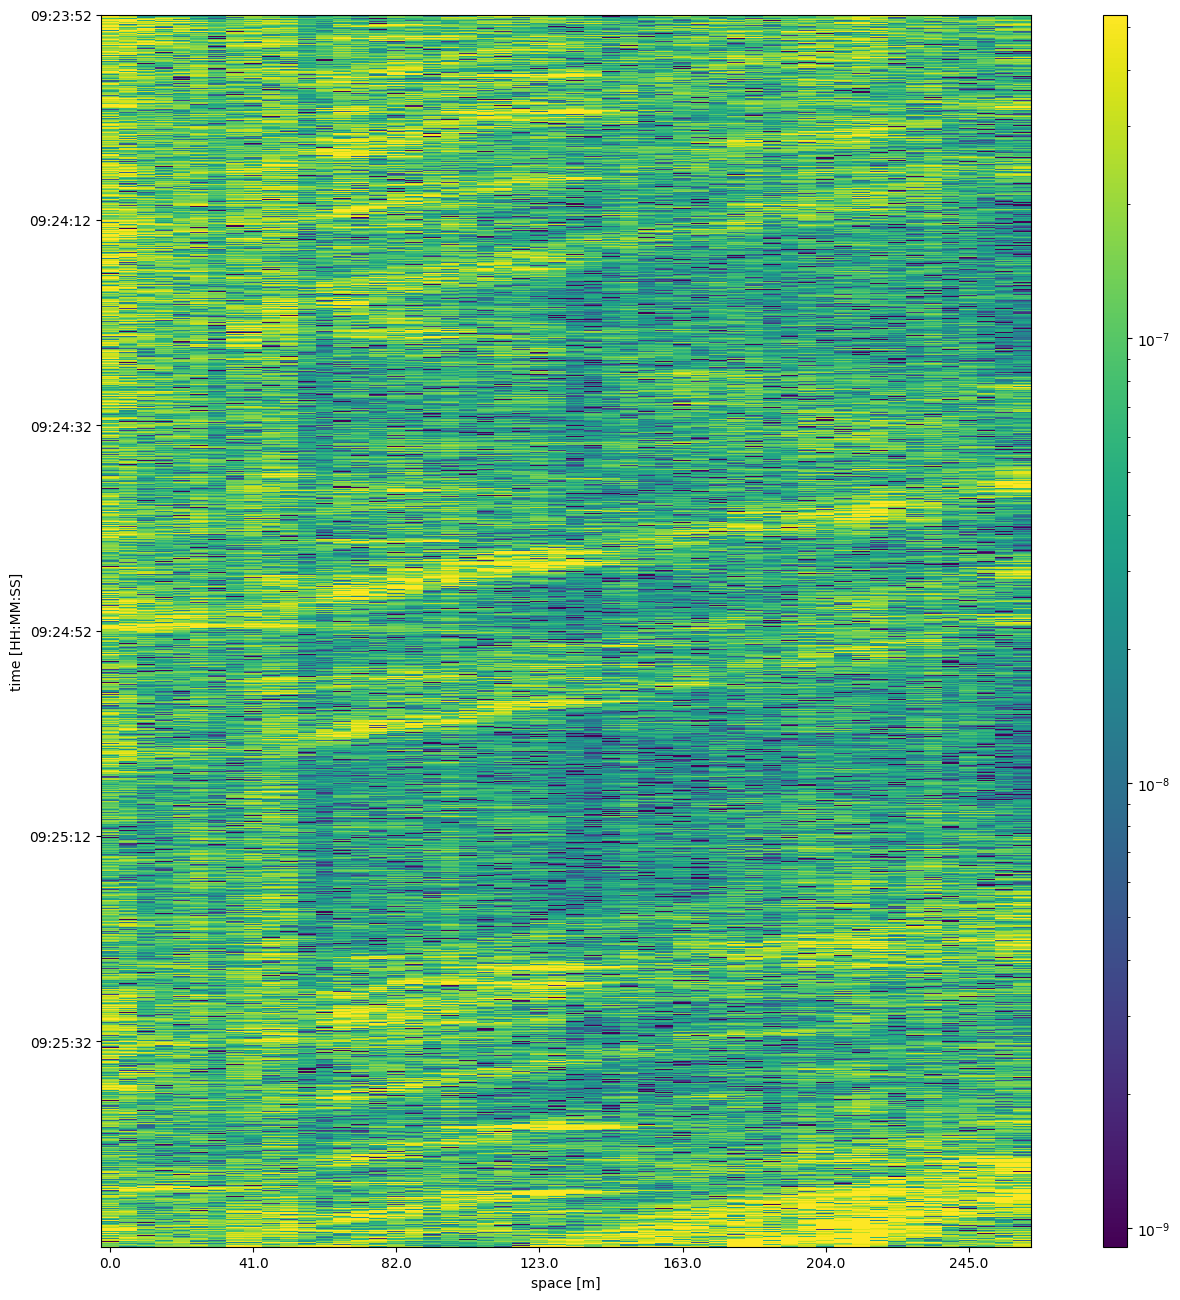

In [28]:
low, high = np.percentile(df, [2, 98]) 
norm_log = LogNorm(vmin=low, vmax=high, clip=True)

plotting_function(abs(df.values), df.index, df.columns, norm_log)

## **2.5.4. Power Norm Scaling** ##

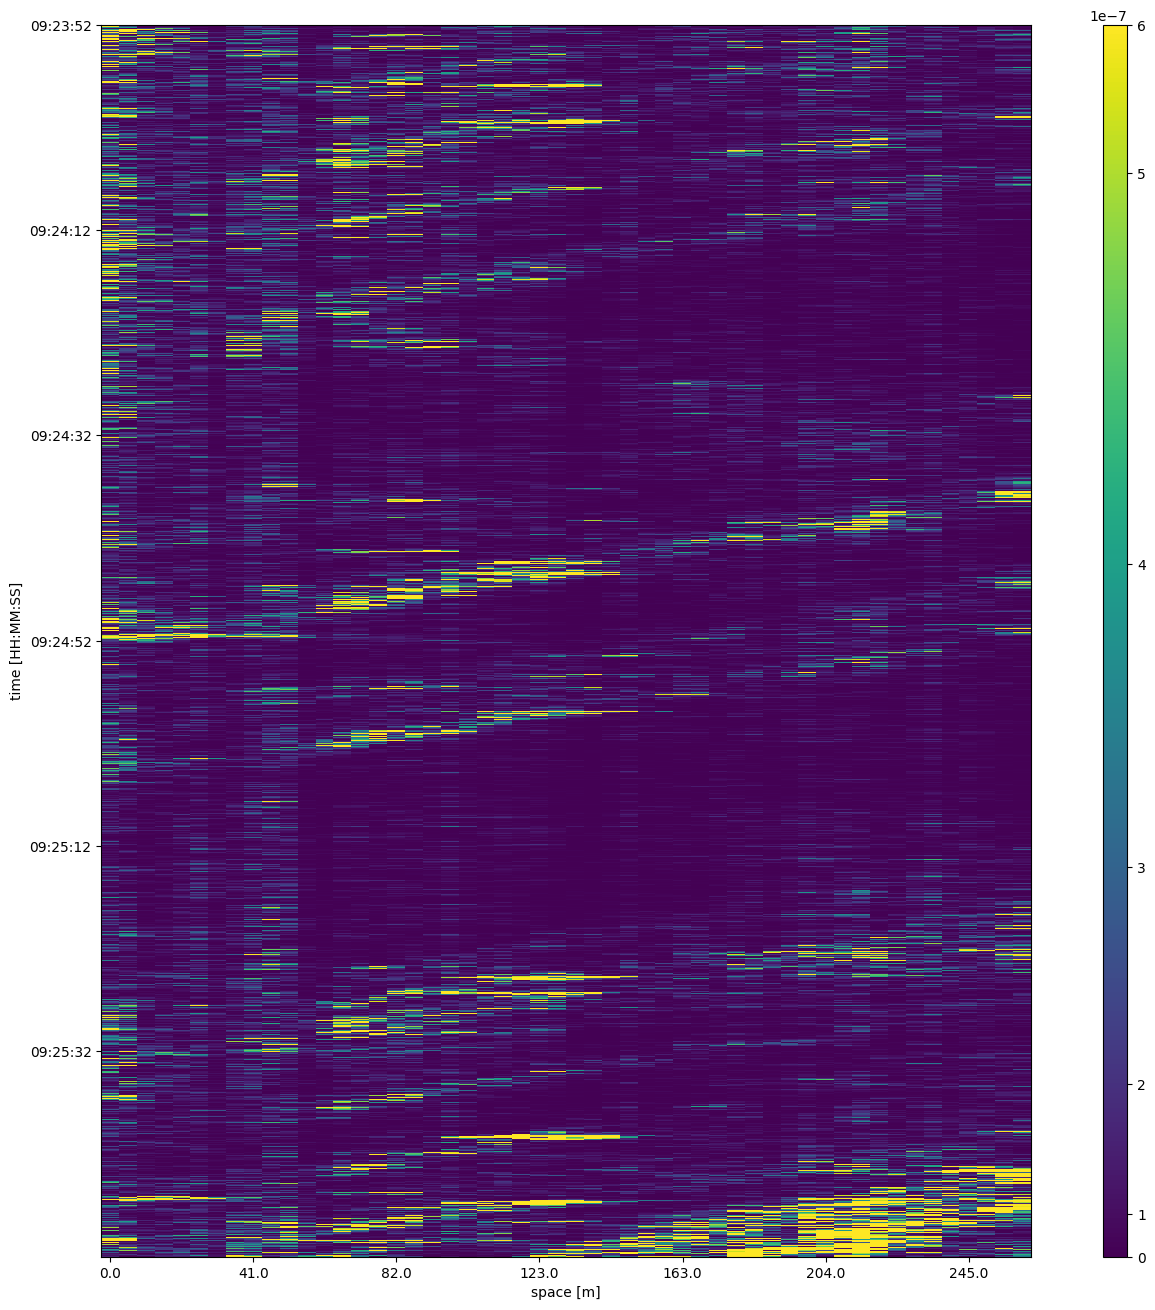

In [29]:
low, high = np.percentile(df, [2, 98]) 
norm_power = PowerNorm(vmin=low, vmax=high, clip=True, gamma = 2) #The higher gamma, the less noise we have in data but also less data

plotting_function(abs(df.values), df.index, df.columns, norm_power)

### **2.5.5. Standardized data** ###

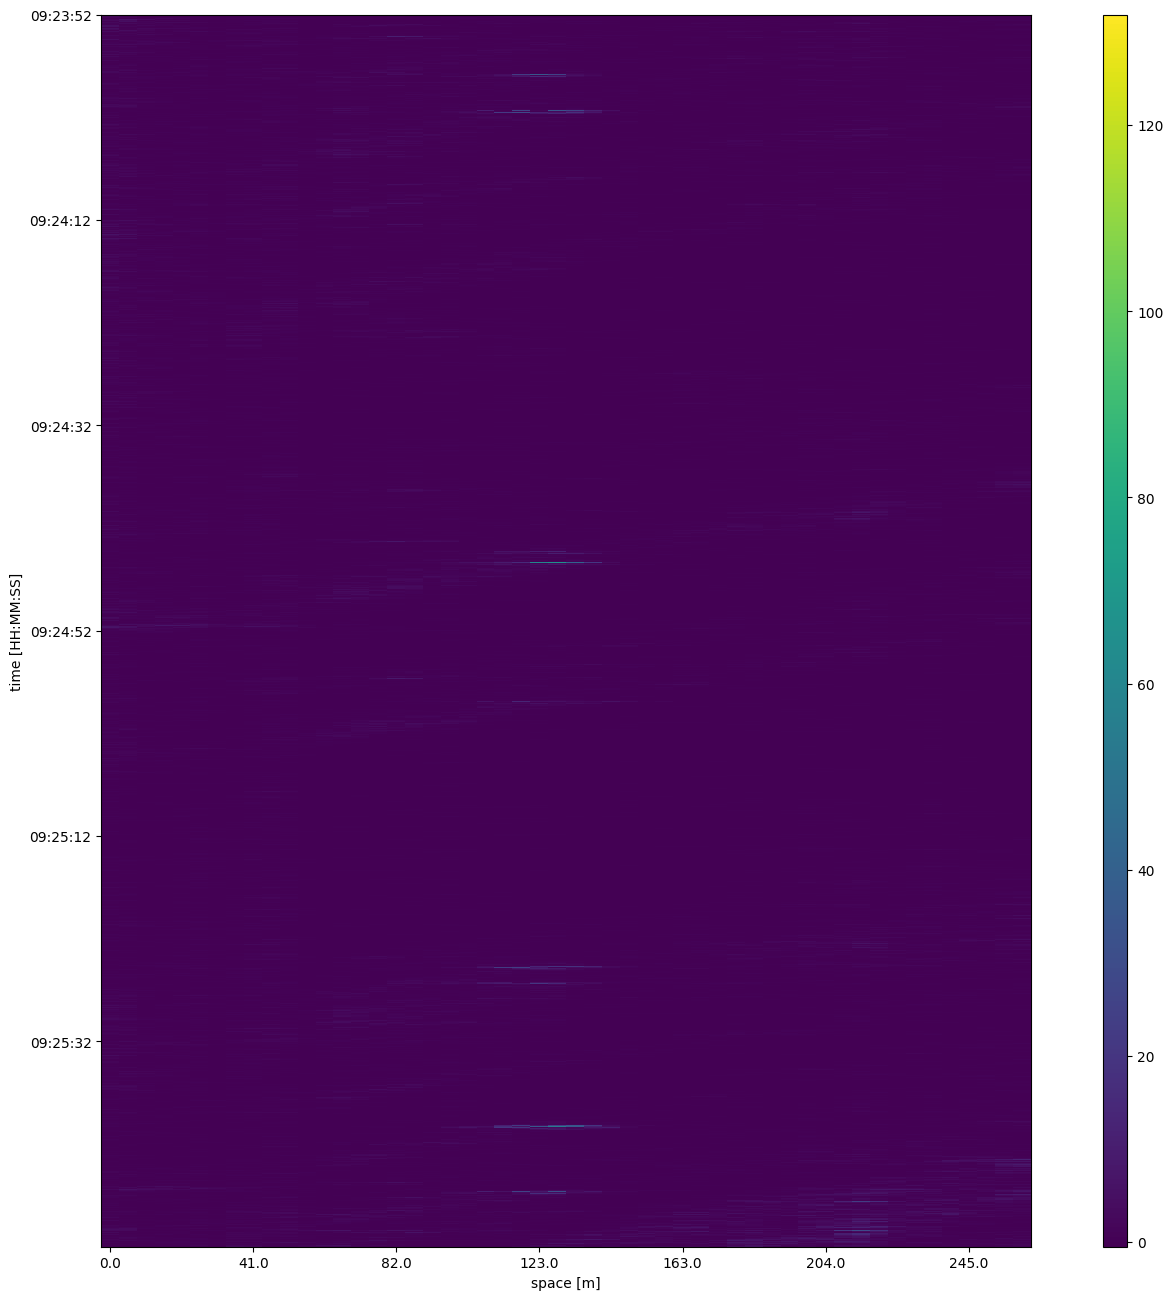

In [30]:
standardized_data = (abs(df.values) - np.mean(abs(df.values))) / np.std(abs(df.values))

plotting_function(standardized_data, df.index, df.columns)

### **2.5.6. Binarized Image** ###

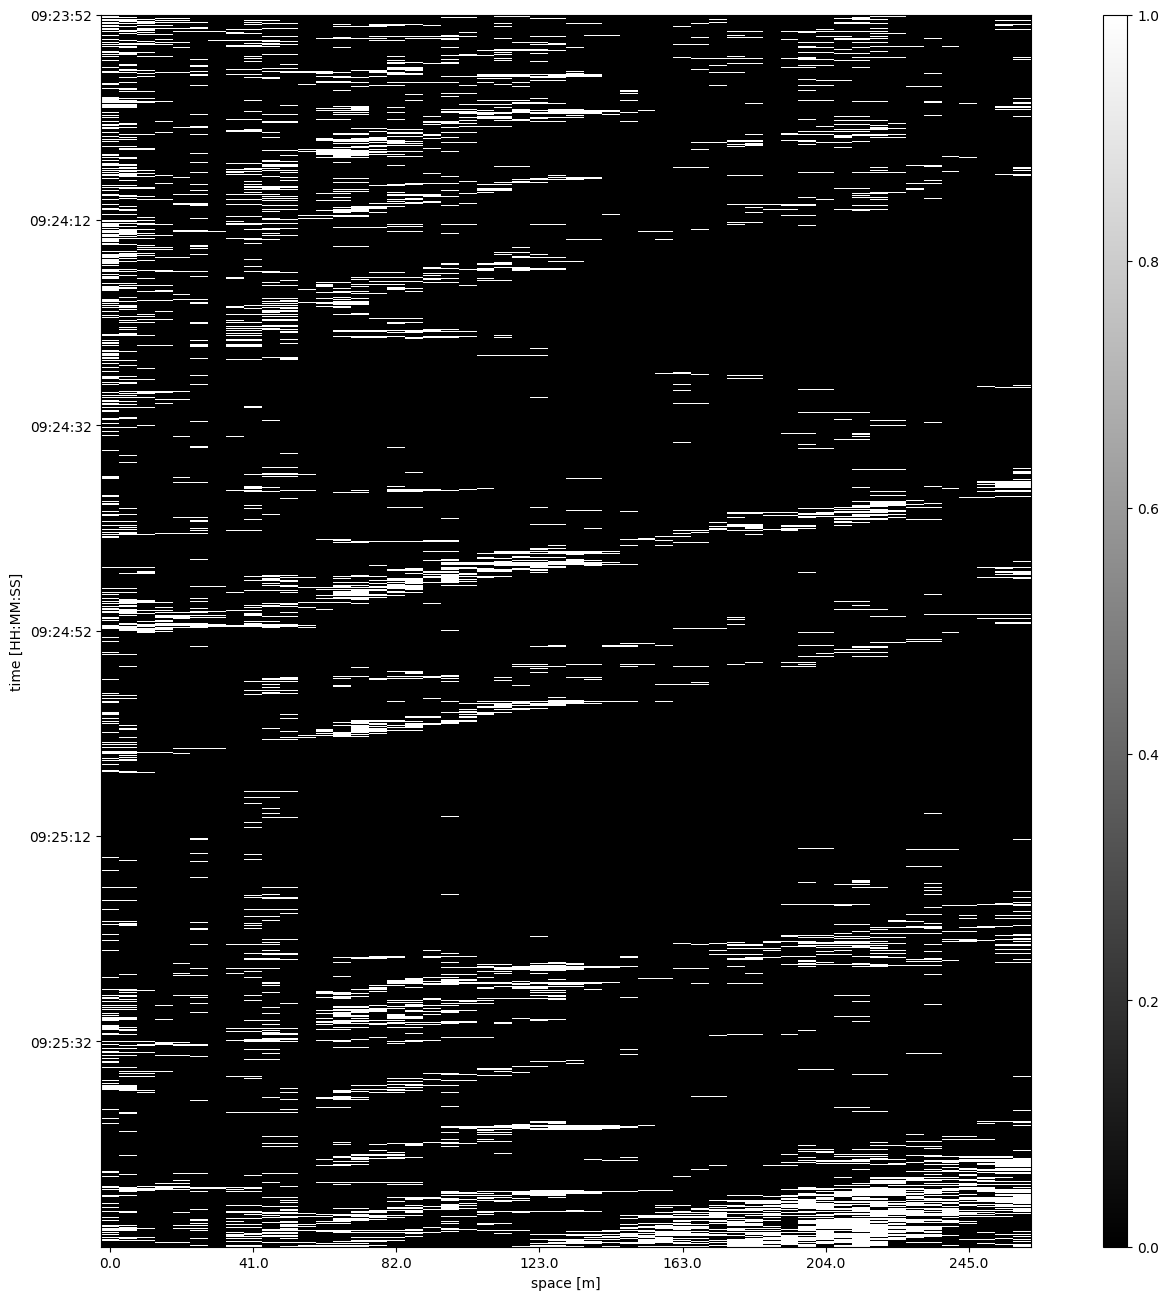

In [32]:
norm_mm_data = norm_mm(abs(df.values))

threshold = np.percentile(standardized_data, [86])
binarized_img = norm_mm_data > threshold
plotting_function(binarized_img, df.index, df.columns, cmap = 'gray') # we use cmap = 'grey' to visualize how would that look like in grayscale image. Here we use our custom function
# to preserve important details of our graph - axes, shape etc

## **2.6. Morphological operations** ##

#### **2.6.1. Proper Closing** ####

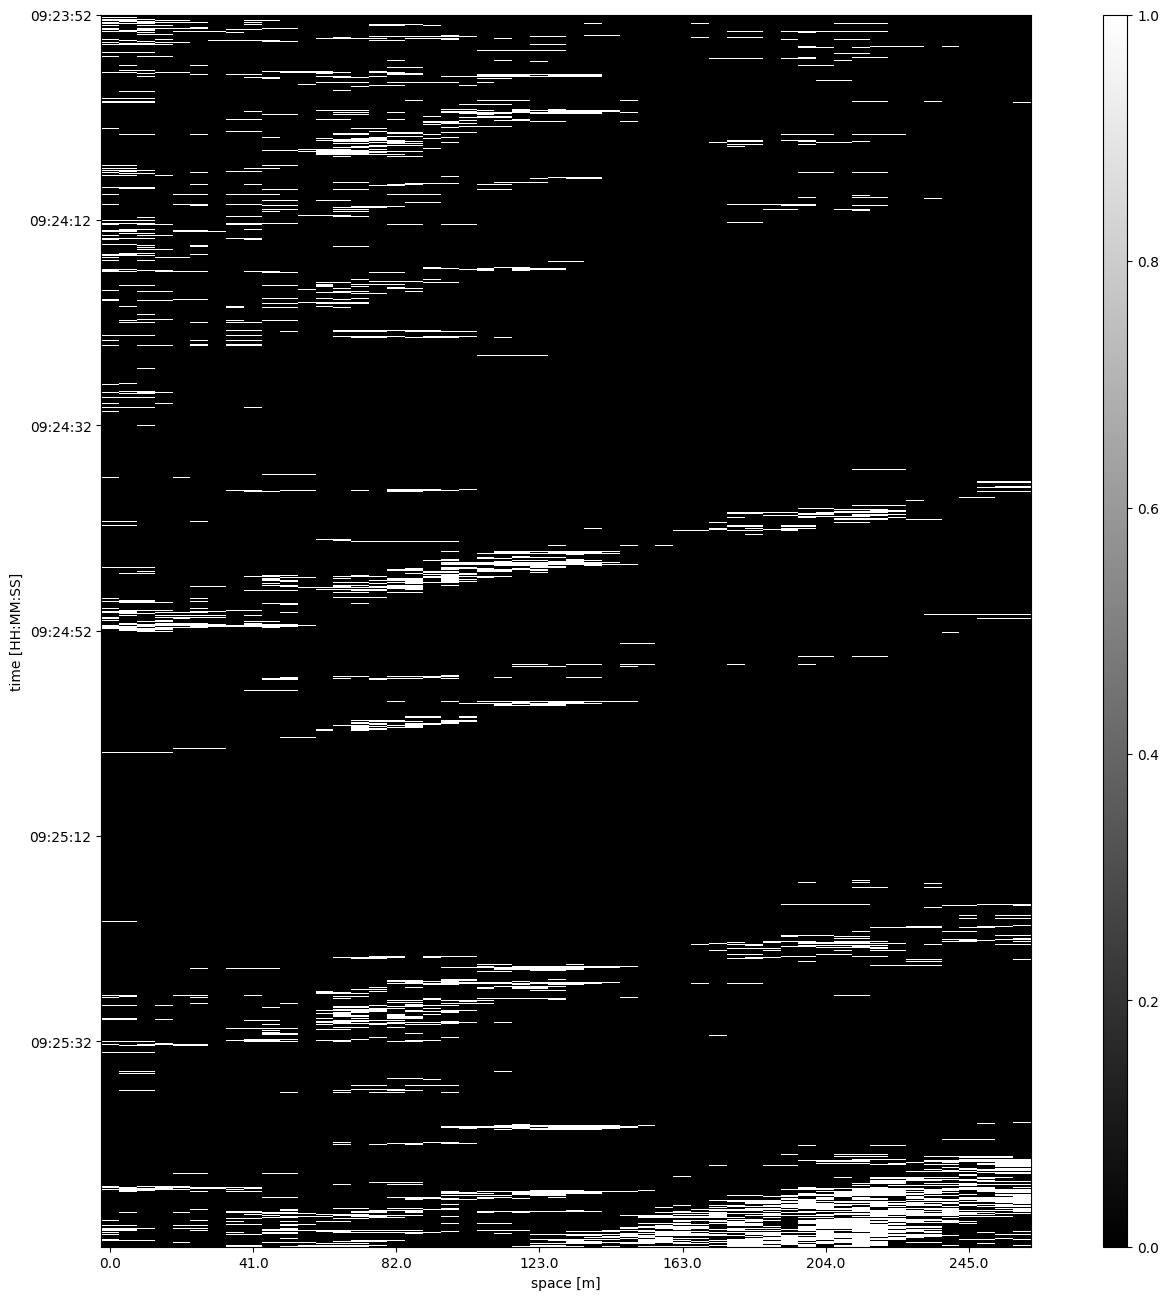

In [34]:
struct = np.ones([5, 5], np.uint8)

operation_1a = cv2.morphologyEx(binarized_img.astype(np.uint8) * 255, cv2.MORPH_CLOSE, struct)
operation_1b = cv2.morphologyEx(operation_1a, cv2.MORPH_OPEN, struct)
operation_1c = cv2.morphologyEx(operation_1b, cv2.MORPH_CLOSE, struct)
operation_1 = np.minimum(binarized_img, operation_1c)

plotting_function(operation_1, df.index, df.columns, cmap = 'grey')

#### **2.6.2. Proper Opening** ####

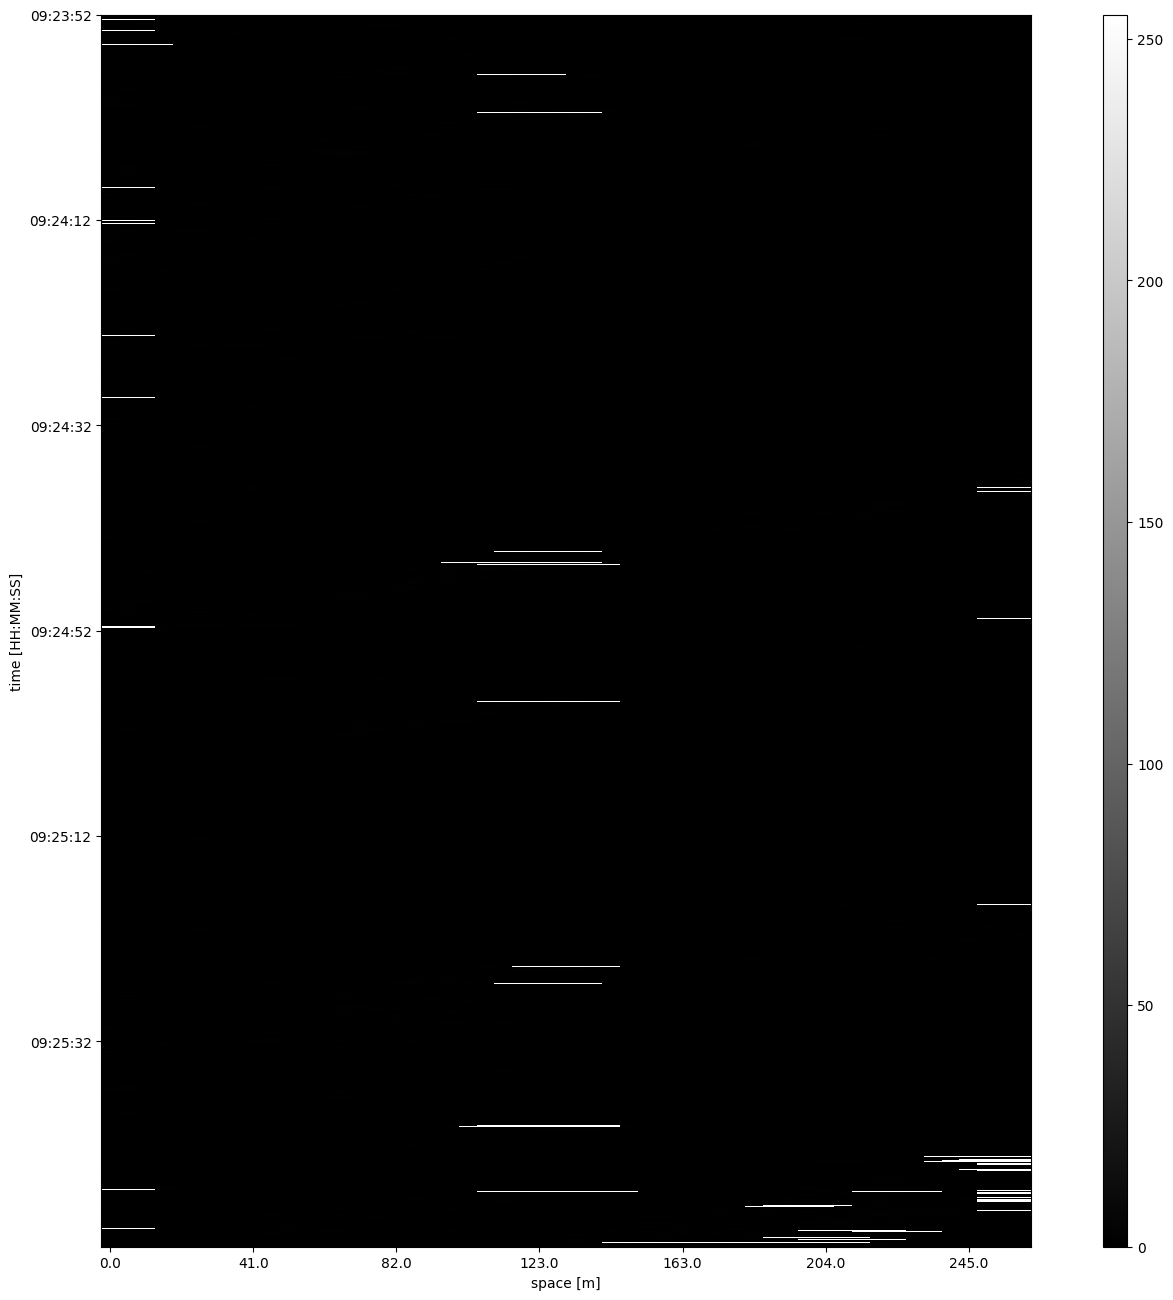

In [35]:
operation_2a = cv2.morphologyEx(binarized_img.astype(np.uint8) * 255, cv2.MORPH_OPEN, struct)
operation_2b = cv2.morphologyEx(operation_2a, cv2.MORPH_CLOSE, struct)
operation_2c = cv2.morphologyEx(operation_2b, cv2.MORPH_OPEN, struct)
operation_2 = np.maximum(binarized_img, operation_2c)

plotting_function(operation_2, df.index, df.columns, cmap = 'grey')

### **2.6.3. Automedian Filter** ###

In [36]:
def automedian_filter(img, struct):
    img_c = cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct)
    img_co = cv2.morphologyEx(img_c, cv2.MORPH_OPEN, struct)
    img_coc = cv2.morphologyEx(img_co, cv2.MORPH_CLOSE, struct)

    img_o = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct)
    img_oc = cv2.morphologyEx(img_o, cv2.MORPH_CLOSE, struct)
    img_oco = cv2.morphologyEx(img_oc, cv2.MORPH_OPEN, struct)

    Q_f = np.minimum(img_coc, img)
    A_f = np.maximum(Q_f, img_oco)

    return A_f

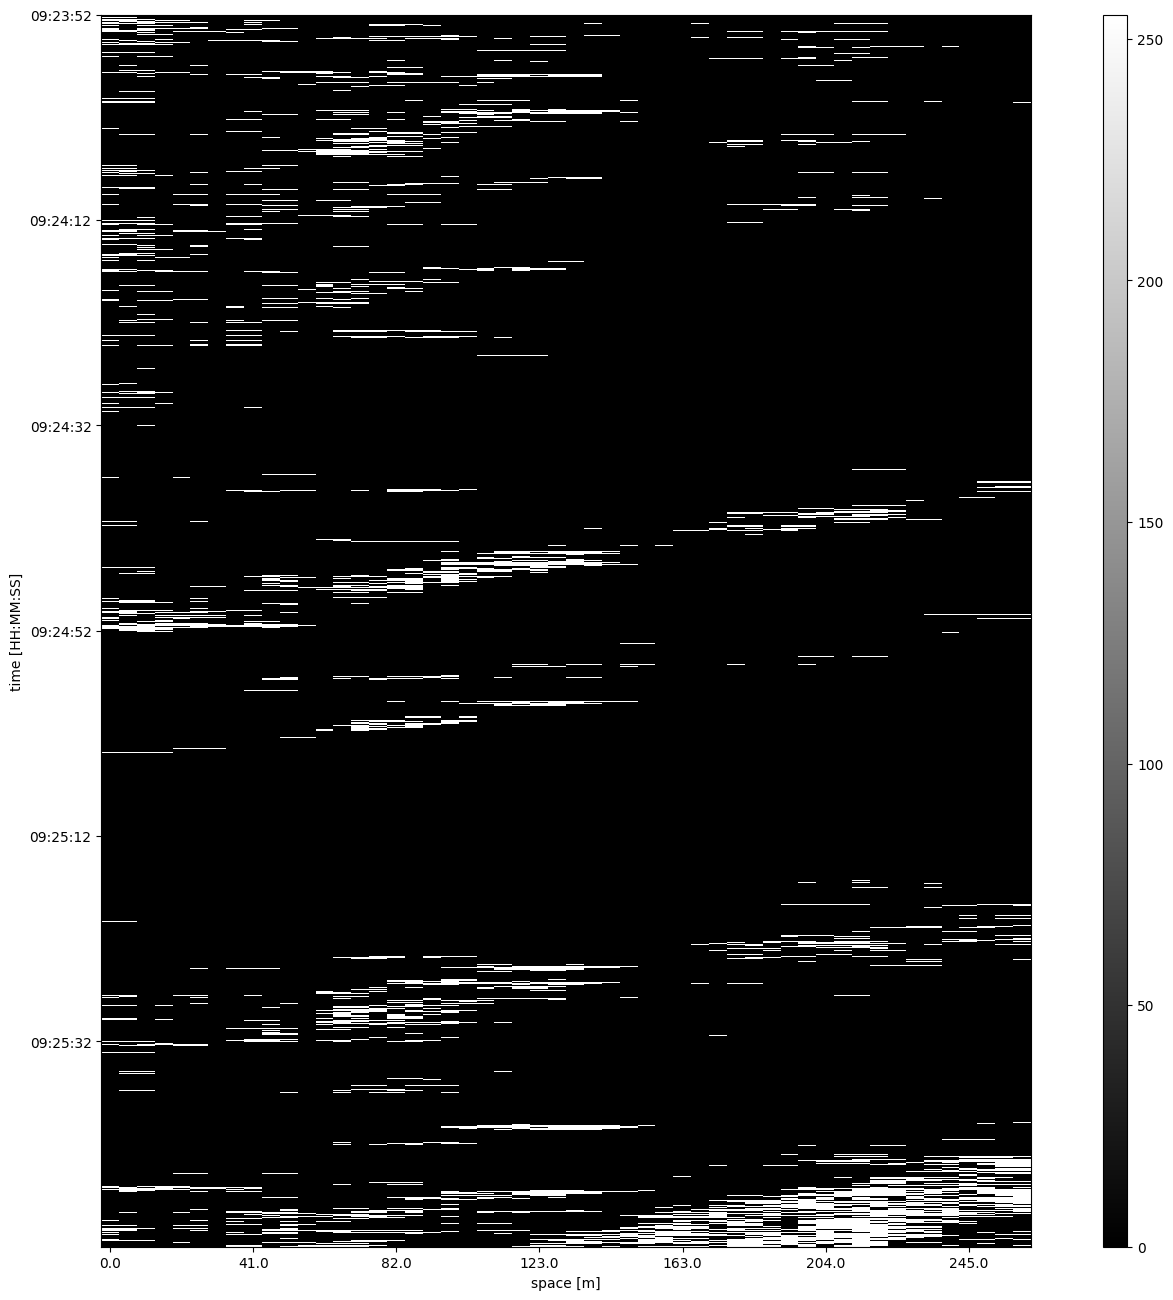

In [38]:
operation_3 = automedian_filter(binarized_img.astype(np.uint8) * 255, struct) # AUTOMEDIAN FILTER
plotting_function(operation_3, df.index, df.columns, cmap = 'grey')

### **2.6.4. Automedian filter, then proper closing** ###

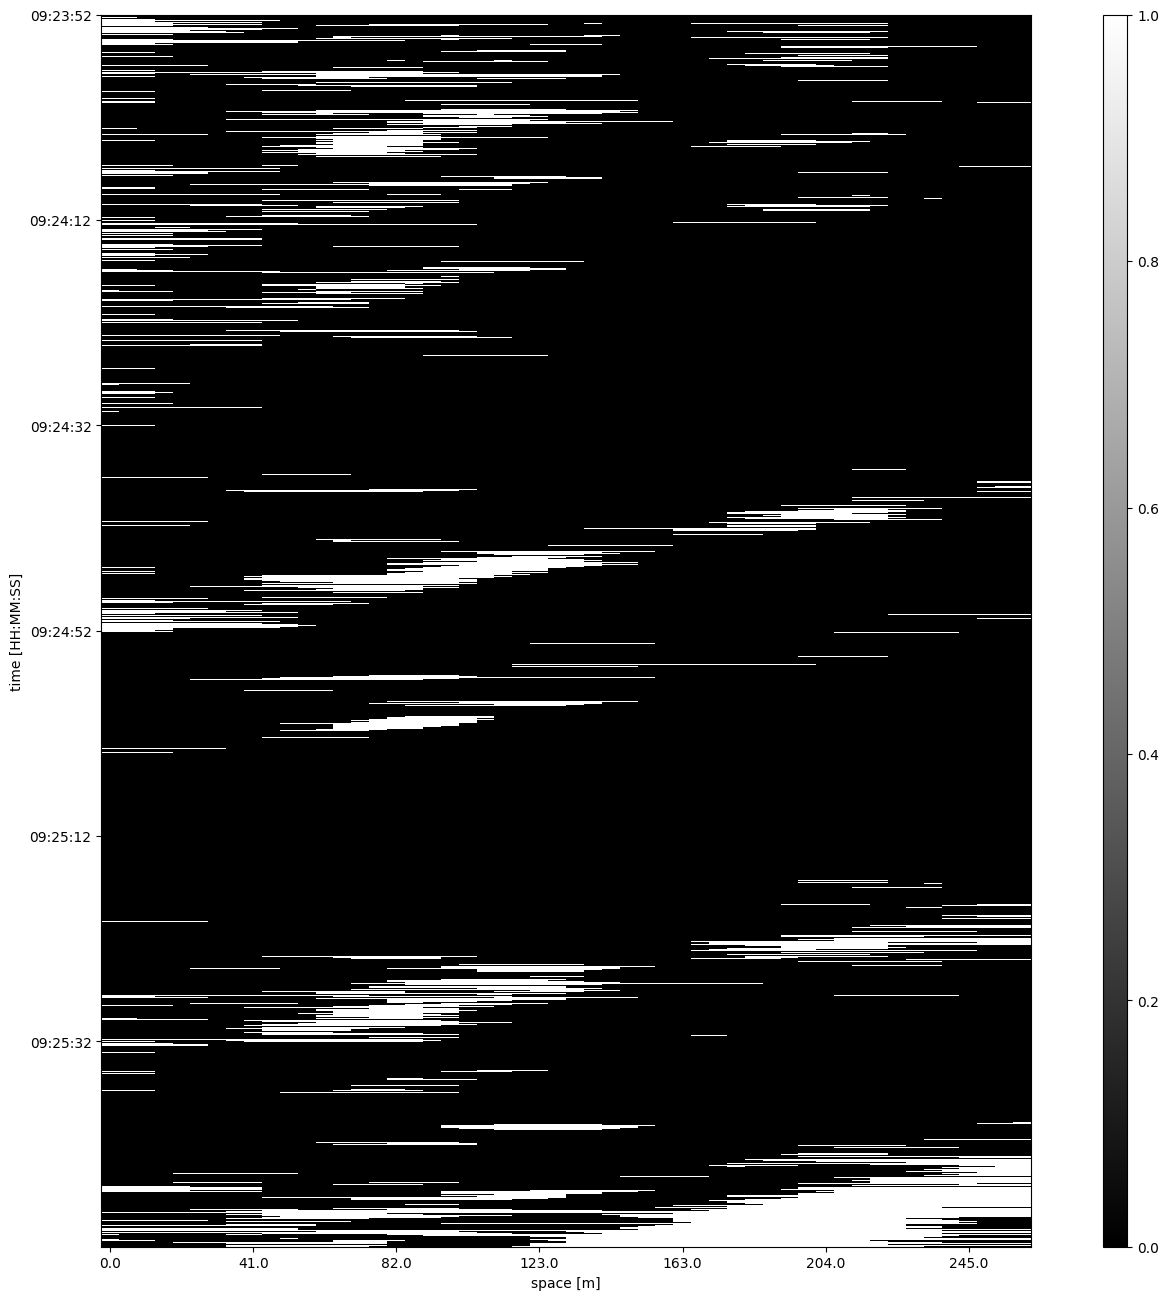

In [39]:
operation_4 = cv2.morphologyEx(operation_3.astype(np.uint8) * 255, cv2.MORPH_CLOSE, struct) # AUTOMEDIAN FILTER, CLOSING
plotting_function(operation_4, df.index, df.columns, cmap = 'grey')

### **2.6.5. Closing, automedian, automedian** ###

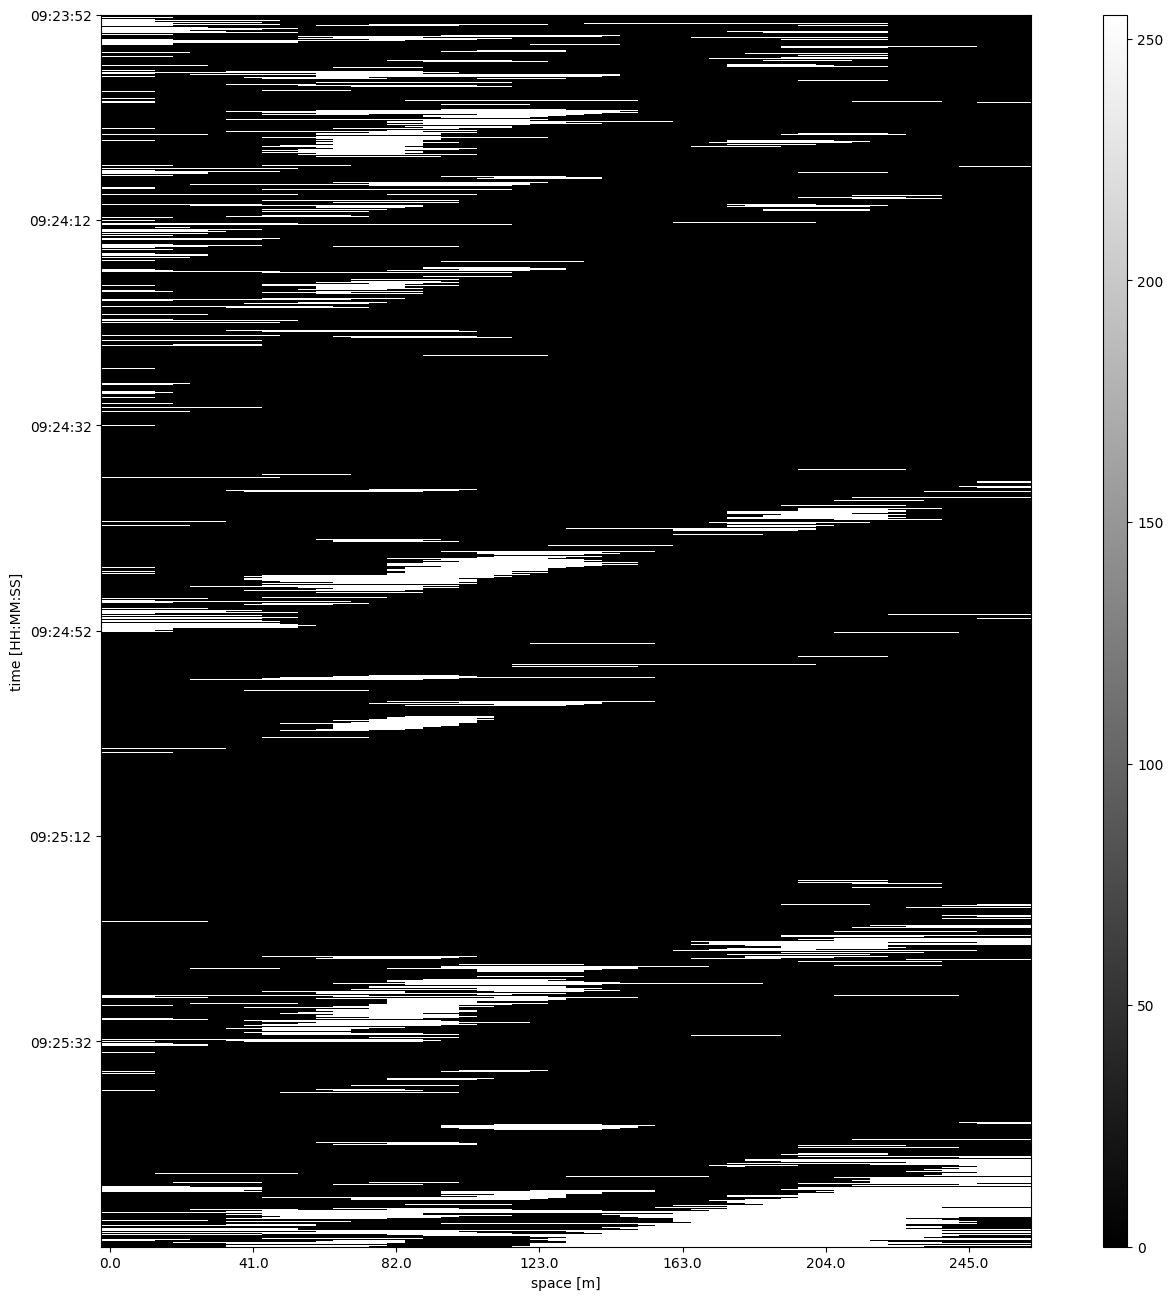

In [40]:
operation_5 = cv2.morphologyEx(binarized_img.astype(np.uint8) * 255, cv2.MORPH_CLOSE, struct) # CLOSING
operation_5 = automedian_filter(operation_5.astype(np.uint8) * 255, struct) # AUTOMEDIAN
operation_5 = automedian_filter(operation_5.astype(np.uint8) * 255, struct) # AUTOMEDIAN 2
plotting_function(operation_5, df.index, df.columns, cmap = 'grey')

# **3. Algorithm** #

## **3.1. Resizing image** ##

Original shape: (75000, 52)
Resized shape: (750, 572)


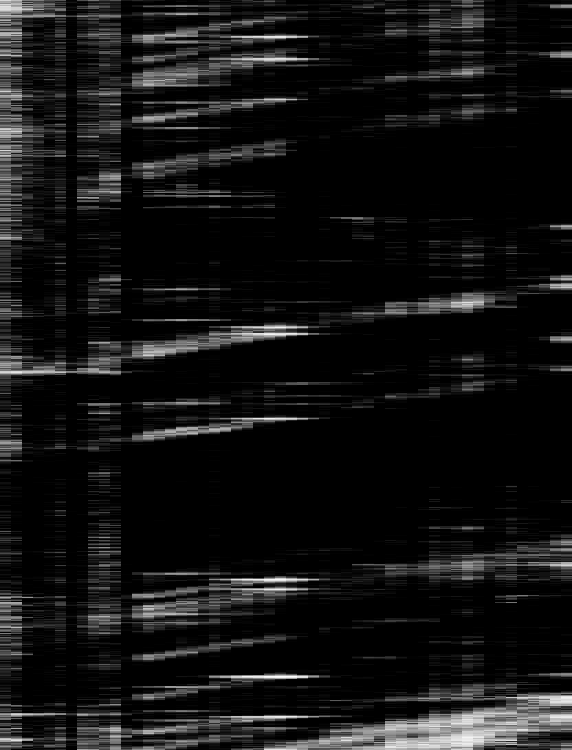

In [45]:
def downsample_vertical(image, factor):
    """
    Reduces the vertical resolution of an image by averaging groups of rows.

    Parameters:
    ----------
    image : ndarray
        The input 2D array representing the image.
    factor : int, optional
        The factor by which to downsample the image vertically.

    Returns:
    -------
    ndarray
        The vertically downsampled image, with the number of rows reduced by the specified factor.
    """
    return image.reshape(image.shape[0] // factor, factor, image.shape[1]).mean(axis=1)


def expand_horizontal(image, factor):
    """
    Expands the horizontal resolution of an image by repeating each pixel value.

    Parameters:
    ----------
    image : ndarray
        The input 2D array representing the image.
    factor : int, optional
        The number of times each pixel value is repeated horizontally.

    Returns:
    -------
    ndarray
        The horizontally expanded image, with the number of columns increased by the specified factor.
    """
    return np.repeat(image, factor, axis=1)


def scale_to_255(image):
    """
    Normalizes an image to the range 0-255.

    Parameters:
    ----------
    image : ndarray
        The input 2D array representing the image.

    Returns:
    -------
    ndarray
        The normalized image scaled to the range 0-255 and converted to uint8.
    """
    scaled_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return (scaled_image * 255).astype(np.uint8)


downsampled_img = downsample_vertical(binarized_img, factor=100)
resized_img = expand_horizontal(downsampled_img, factor=11)

print(f"Original shape: {norm_mm_data.shape}")
print(f"Resized shape: {resized_img.shape}")

scaled_img = scale_to_255(resized_img)

imshow(scaled_img)

As we can see, our axes went from being unreasonable to being close to 4:3. The above resizing will be helpful. First of all, number of values decreased more less 10 times but information was mostly preserved (we stretched horizontal axis and squeezed vertical one).

## **3.2. Lines detection** ##

To detect lines we will use Hough algorithm and we will do it twice. 

First of all, we will detect most obvious lines that span from one vertical edge to another vertical edge.

However, there are some lines that are not so easy to be detected - lines that start on one type of edge and finish on the other one (e.g. edge that is in lower right corner - it starts on horizontal edge and finishes on vertical edge). Here we will first pad the image from above and below (we will use edge padding of width 15% from each side; padding with 0 gave either poor or no results). Then we will run Hough lines algorithm. 

Result will be sum of both sets of lines.

Finally, we will use some filtering and we will discard lines that make no sens (e. g. lines of slope 0 which would indicate that vehicle moved infinitely fast, lines that are too steep - those indicate that a vehicle moved with no speed, but we know that this is probably due to some noise in the data)

In [47]:
dx= 5.106500953873407
dt= 0.0016

In [48]:
def detect_lines(img, accumulator_threshold):
    """
    Detects prominent lines in an image using the Hough Transform.

    Parameters:
    ----------
    img : ndarray
        The input 2D array representing the image.
    accumulator_threshold : int or float
        The minimum accumulator value required to consider a line as valid.
        Higher values correspond to stronger detected lines.
        
    Returns:
    -------
    list of tuples
        A list of detected lines, where each line is represented as a tuple:
        (distance, angle, slope, speed).
        - `distance`: Distance from the origin to the line.
        - `angle`: Angle of the line in radians.
        - `slope`: Slope of the line.
        - `speed`: Vehicle speed calculated based on the line's slope.
    """
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(img, theta=tested_angles)

    lines = []
    for accumulator, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        slope = np.tan(angle + np.pi / 2)
        denominator = slope * 1100 * dt / dx
        speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
        if 40 < speed < 130 and accumulator > accumulator_threshold:
            lines.append((dist, angle, slope, speed))
    
    return lines


def detect_lines_close_boundaries(img, pad_size, accumulator_threshold):
    """
    Detects prominent lines near the top and bottom boundaries of an image using padding and the Hough Transform.

    Parameters:
    ----------
    img : ndarray
        The input 2D array representing the image.
    pad_size : float
        Fraction of the image height to use as padding size.
    accumulator_threshold : int or float
        The minimum accumulator value required to consider a line as valid.
        Higher values correspond to stronger detected lines.

    Returns:
    -------
    list of tuples
        A list of detected lines close to the image boundaries, where each line is represented as a tuple:
        (distance, angle, slope, speed).
    """
    pad_h = int(pad_size * img.shape[0])
    img_pad = np.pad(img, ((pad_h, pad_h), (0, 0)), "edge")
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(img_pad, theta=tested_angles)

    pad_lines = []
    for accumulator, angle, dist in zip(*hough_line_peaks(h, theta, d)): 
        slope = np.tan(angle + np.pi / 2)
        denominator = slope * 1100 * dt / dx
        speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
        if 40 < speed < 120 and accumulator > accumulator_threshold and (750 < np.abs(dist-pad_h) or np.abs(dist-pad_h) < 100):
            pad_lines.append((dist-pad_h, angle, slope, speed))
    
    return pad_lines

In [49]:
def filter_lines(lines, distance_threshold):
    """
    Filters detected lines based on distance, speed, and slope criteria to identify true prominent lines.
    Specificaly it confirms line if it is: first or further than distance_threshold from previous line
    or has lower speed or is in opposite direction.

    Parameters:
    ----------
    lines : list of tuples
        A list of detected lines descendingly sorted by distance, where each line is represented as a tuple:
        (distance, angle, slope, speed).

    Returns:
    -------
    list of tuples
        A filtered list of lines satisfying the criteria, where each line is represented as a tuple:
        (distance, angle, slope, speed).
    """
    true_lines = []
    previous_dist = None
    previous_speed = None
    previous_slope = None

    for dist, angle, slope, speed in lines:
        if previous_dist is None or previous_dist - dist > distance_threshold or speed < previous_speed or slope * previous_slope < 0:
            true_lines.append((dist, angle, slope, speed))
            
            previous_dist = dist
            previous_speed = speed
            previous_slope = slope
    
    return true_lines

In [50]:
def display_lines_on_scaled_img(img, lines):
    """
    Displays detected lines overlaid on the scaled image.

    Parameters:
    ----------
    img : ndarray
        The input 2D array representing the image.
    lines : list of tuples
        A list of detected lines, where each line is represented as a tuple:
        (distance, angle, slope, speed).

    Returns:
    -------
    None
        Displays the plot with lines overlaid on the input image.
    """
    fig, ax = plt.subplots(figsize=(12, 16))
    ax.imshow(img)
    ax.set_ylim((img.shape[0], 0))
    ax.set_xlim((0, img.shape[1]))

    for dist, angle, slope, _ in lines:
        x0, y0 = (dist) * np.array([np.cos(angle), np.sin(angle)])
        ax.axline(
                (x0, y0),
                slope=slope,
                color='red',
                linewidth=2,
                linestyle='--',
            )
        
    plt.tight_layout()

/var/folders/8m/nx_b_wh17dg77b9kb95gxng80000gp/T/ipykernel_31836/2407331224.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
/var/folders/8m/nx_b_wh17dg77b9kb95gxng80000gp/T/ipykernel_31836/2407331224.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)


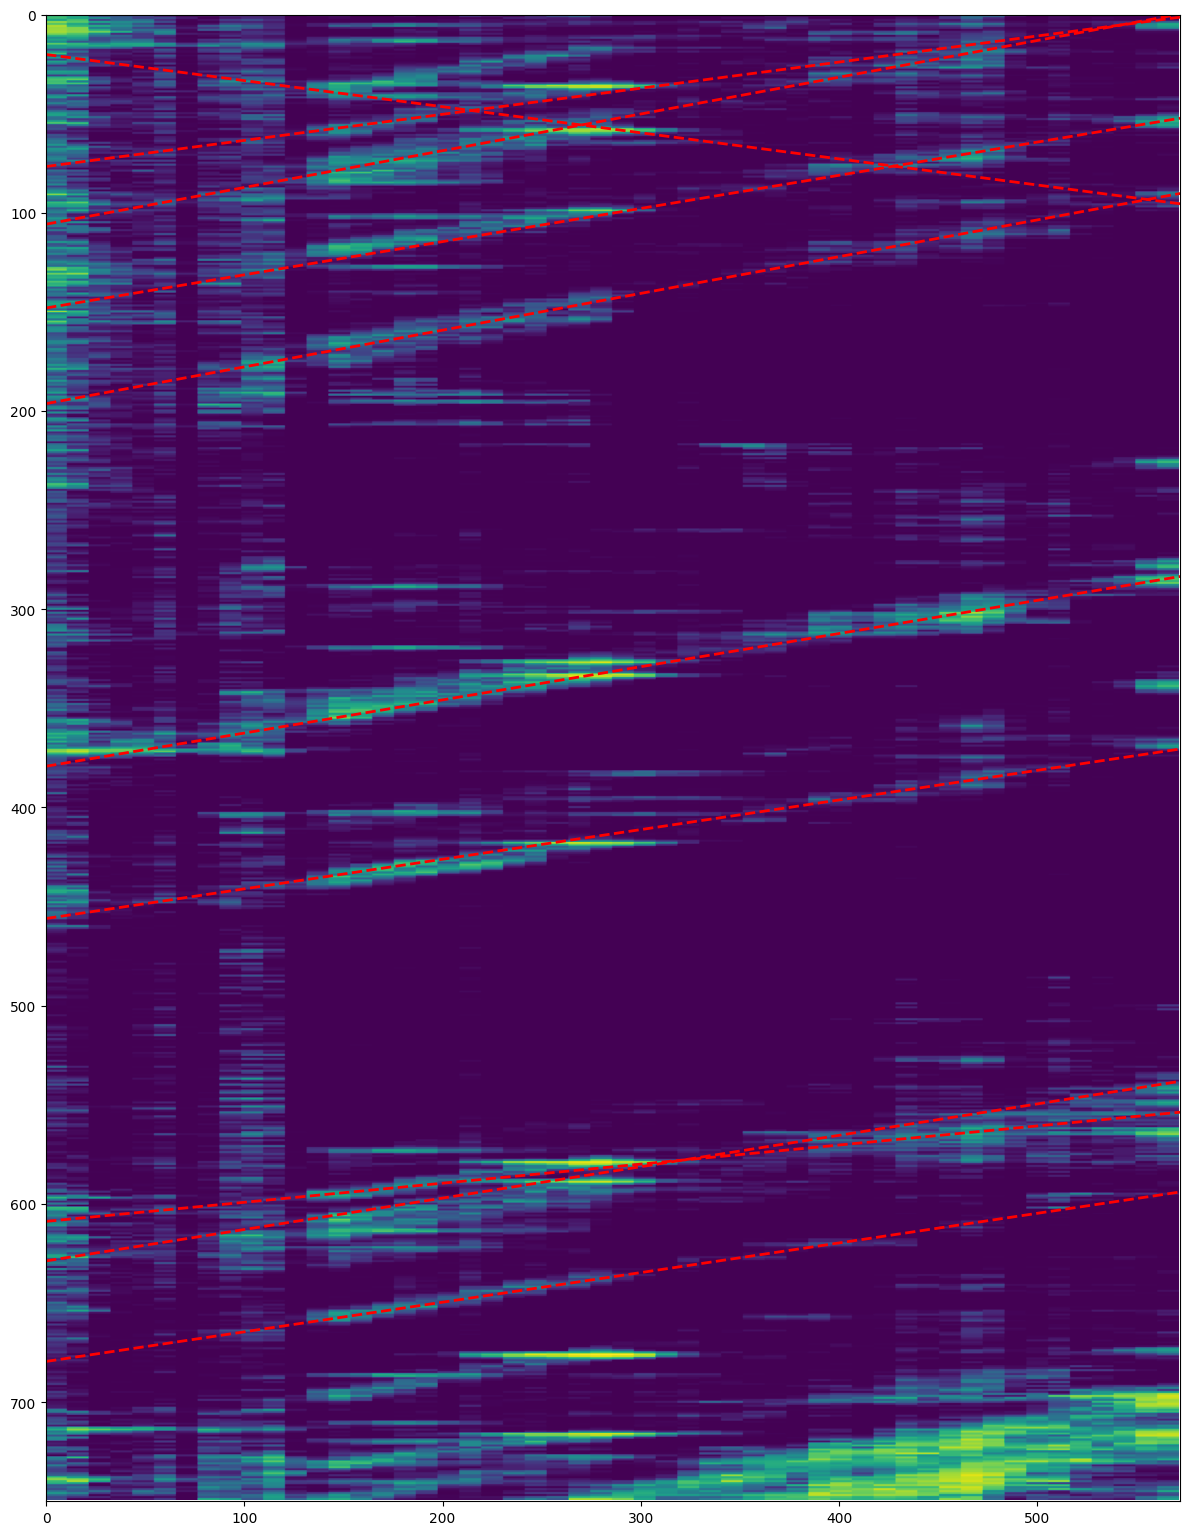

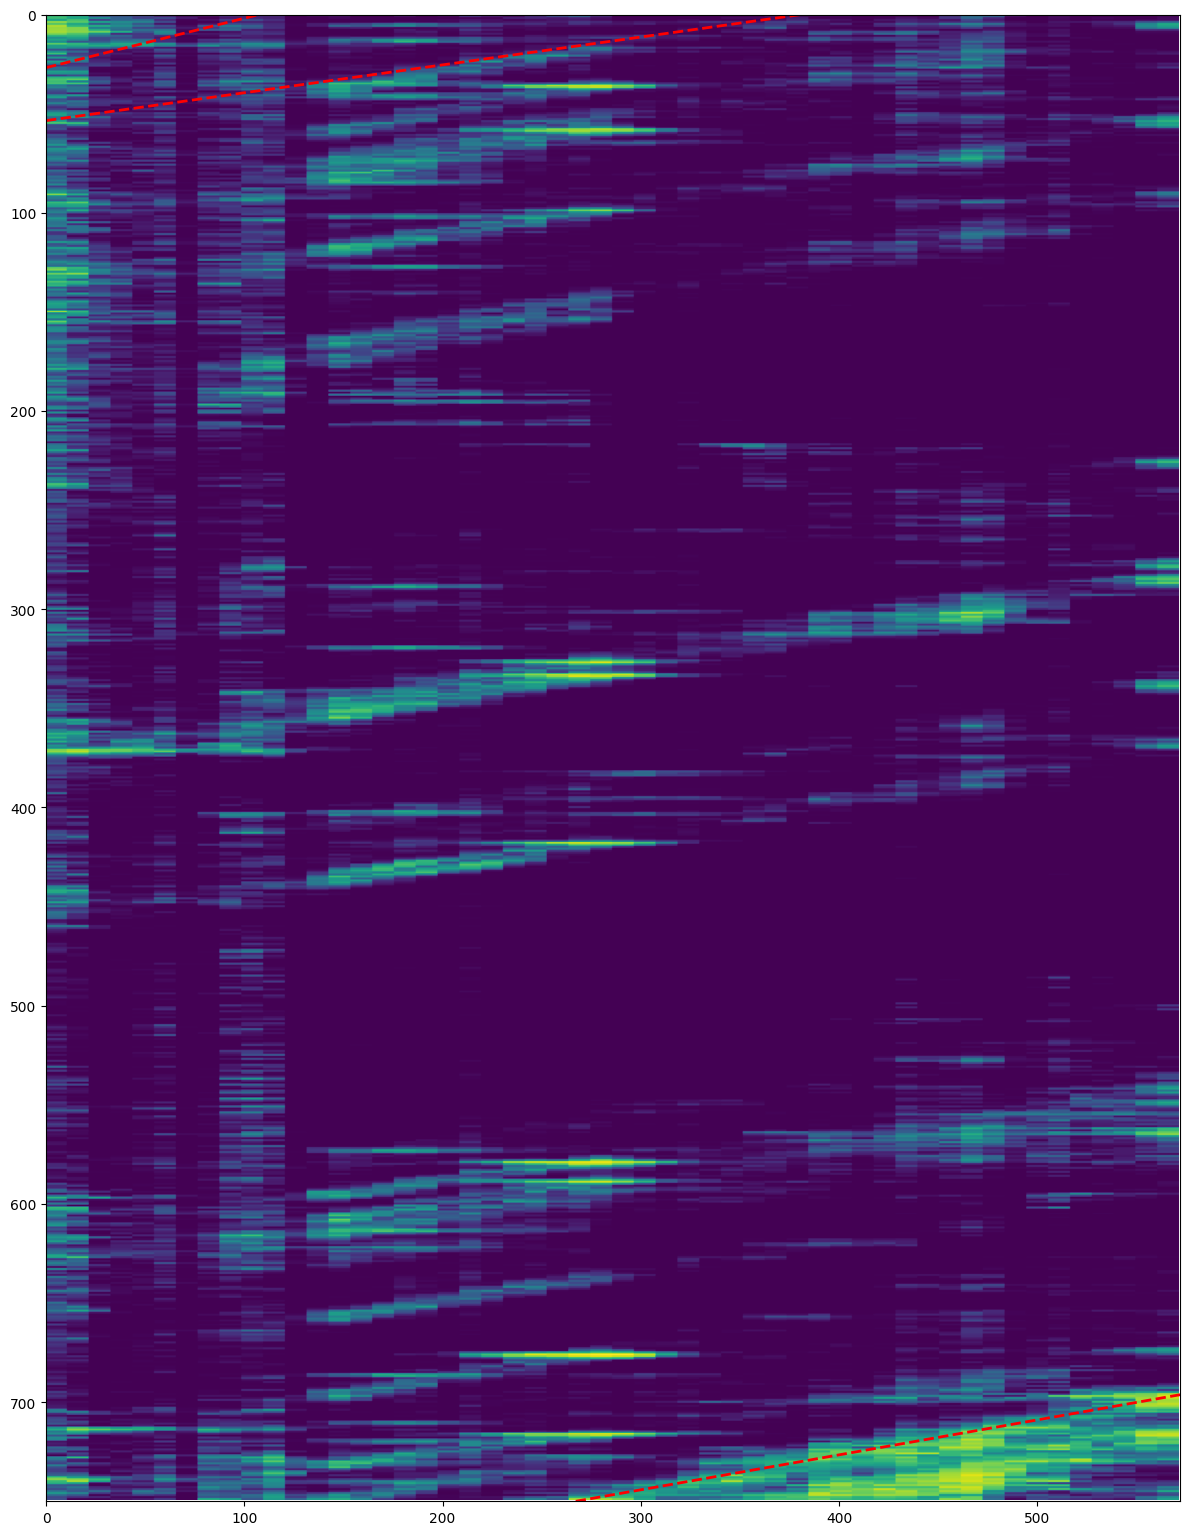

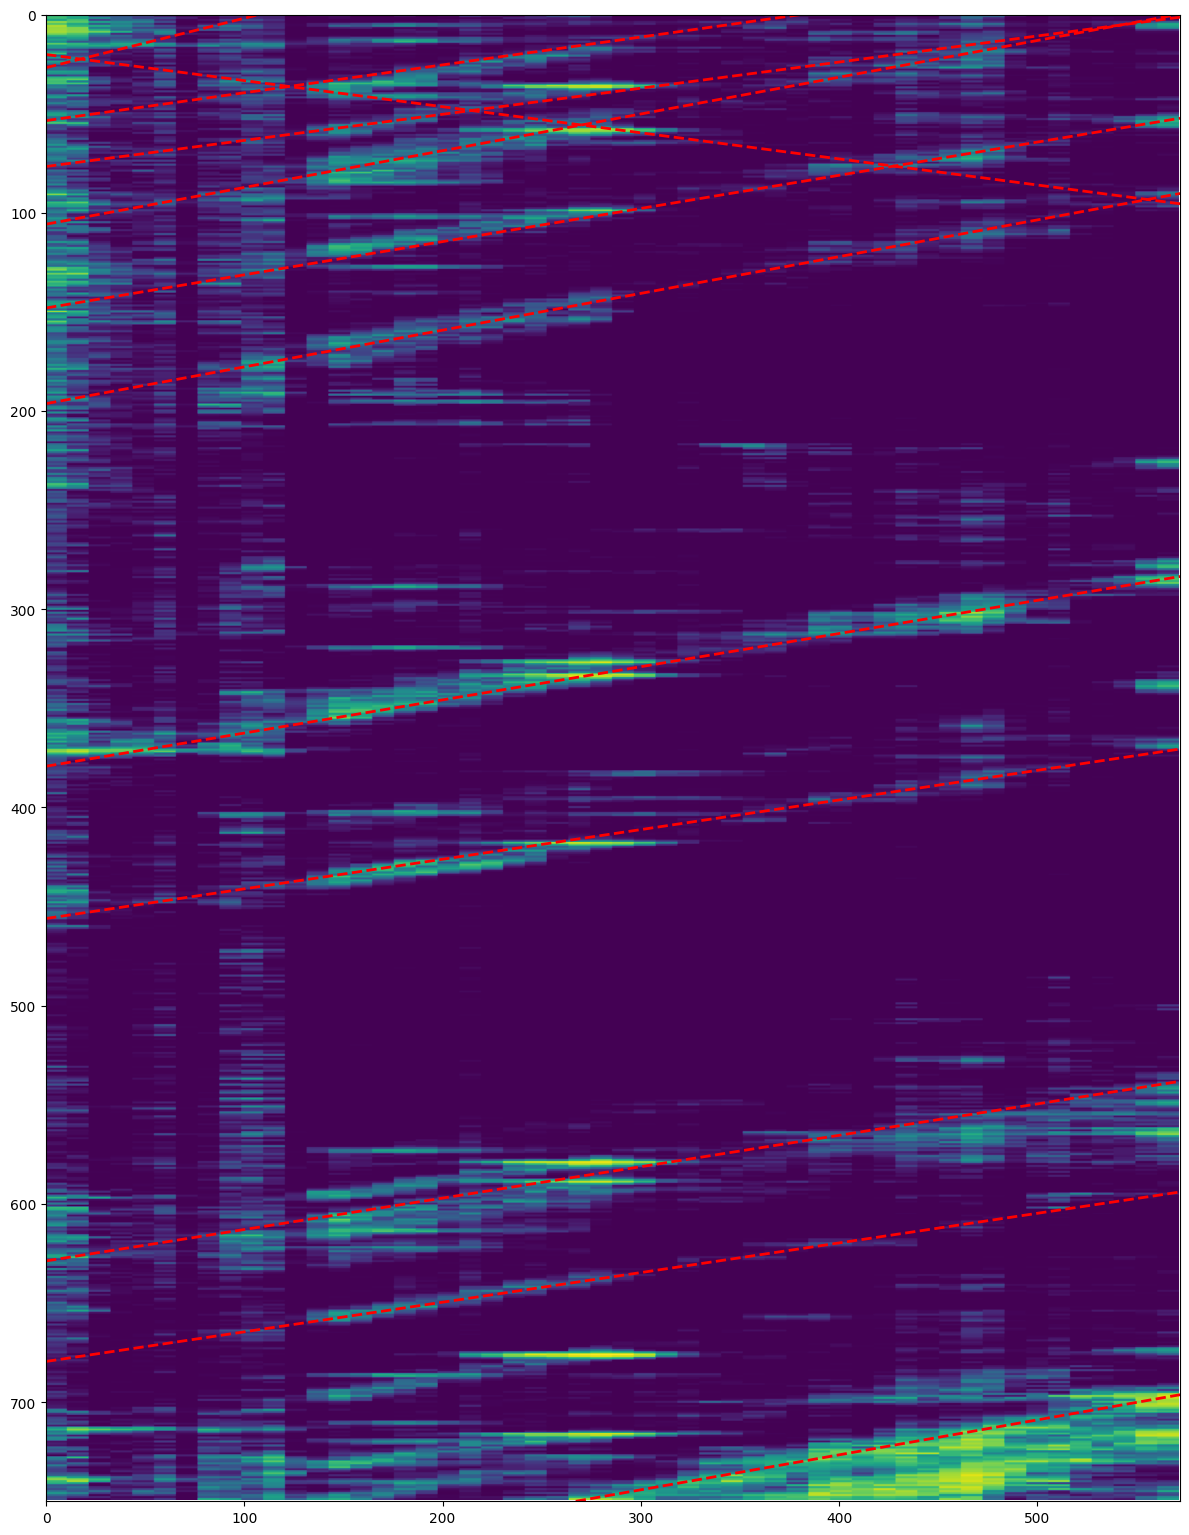

In [57]:
lines = detect_lines(scaled_img, 420)
display_lines_on_scaled_img(scaled_img, lines)

pad_lines = detect_lines_close_boundaries(scaled_img, 0.15, 500)
display_lines_on_scaled_img(scaled_img, pad_lines)

all_lines = lines+pad_lines
sorted_lines = sorted(all_lines, key=lambda x: -x[0])
true_lines = filter_lines(sorted_lines, 25)
display_lines_on_scaled_img(scaled_img, true_lines)

As previously mentioned, we have 3 images. First one shows lines that are obvious, second one shows lines that are in the corners, last one shows both of them. Values of parameters that are obtained were result of experimenting which we didn't include in that notebook to avoid making a mess. 

However, there are two things we need to have in mind - 1) we display images that are rescaled so they are both lacking some information while having more information, 2) we need to calculate speed of each vehicle. Below cells are responsible for that

In [58]:
def display_detected_movements(df, lines, vert_scale, hor_scale):
    """
    Displays a visualization of detected movements with overlaid rescaled detected lines.

    Parameters:
    ----------
    df : pandas.DataFrame
        A 2D DataFrame containing the data to be visualized, where rows correspond to time steps and columns correspond to spatial positions.
        The values in the DataFrame represent the measurements or observations at each time step for each spatial point.

    lines : list of tuples
        A list of detected lines, where each line is represented as a tuple:
        (distance, angle, slope, speed).
    vert_scale : float
        Scaling factor to rescale vertical dimensions of the detected lines.
    hor_scale : float
        Scaling factor to rescale horizontal dimensions of the detected lines.

    Returns:
    -------
    None
        Displays the plot with a heatmap of movements and overlaid rescaled lines, along with labels indicating the speed of the lines.
    """
    fig = plt.figure(figsize=(12, 16))
    ax = plt.axes()

    low, high = np.percentile(df, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)
    im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
    plt.ylabel('time [HH:MM:SS]')
    plt.xlabel('space [m]')

    for dist, angle, slope, speed  in lines:
        (x0, y0) = dist * np.array([np.cos(angle) * hor_scale, np.sin(angle) * vert_scale])
        slope_original = slope * vert_scale/hor_scale

        ax.axline((x0, y0), slope=slope_original, color='red', linewidth=2)
        offset = -700 
        x_text = x0 + 7
        y_text = slope_original * (x_text - x0) + y0 + offset

        if -1000 < y_text < 80000: # filters lines that are only in padded part of padded image
            rotation_angle = np.degrees(np.arctan(slope)) - 20*np.sign(slope)
            ax.text(
                x_text, y_text,
                f"{np.round(speed, 2)} km/h",
                fontsize=12,
                fontweight='bold',
                color='red',
                ha='center',
                va='center',
                rotation=rotation_angle,
                rotation_mode='anchor'
            )

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    ax.set_ylim((74999, 0))
    ax.set_xlim((0, 51))
    plt.show()    

vertical scale: 100.0 horizontal scale: 0.09090909090909091


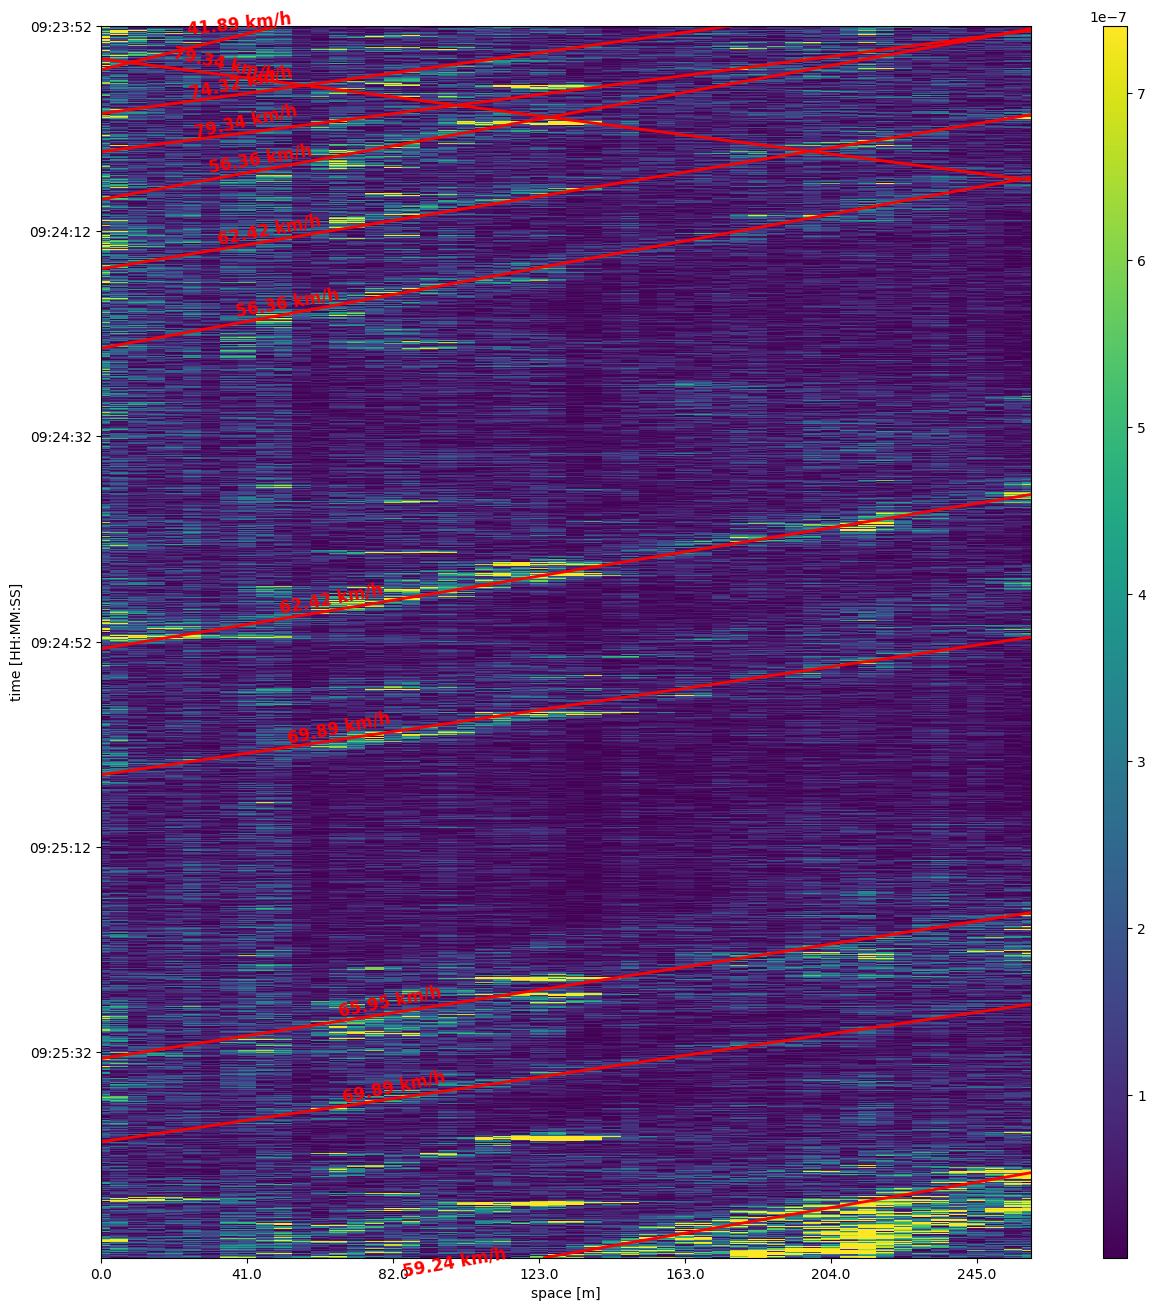

In [59]:
ver_scale = norm_mm_data.shape[0] / scaled_img.shape[0]
hor_scale = norm_mm_data.shape[1] / scaled_img.shape[1]
print("vertical scale:", ver_scale, "horizontal scale:", hor_scale)

display_detected_movements(df, true_lines, ver_scale, hor_scale)

/var/folders/8m/nx_b_wh17dg77b9kb95gxng80000gp/T/ipykernel_31836/2407331224.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
/var/folders/8m/nx_b_wh17dg77b9kb95gxng80000gp/T/ipykernel_31836/2407331224.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)


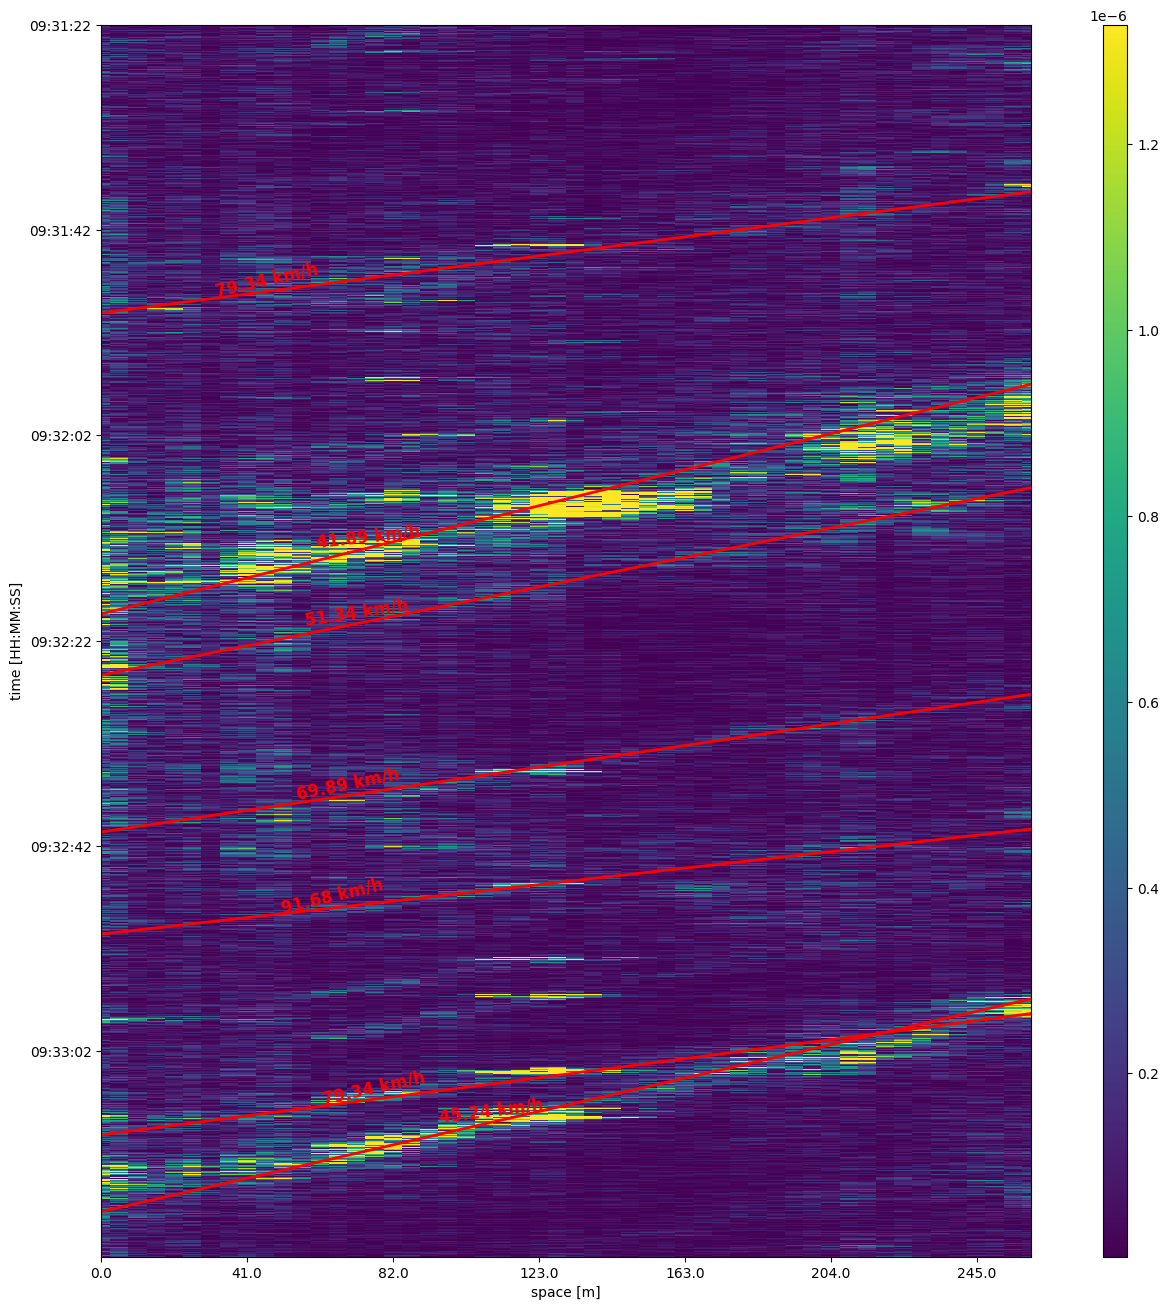

/var/folders/8m/nx_b_wh17dg77b9kb95gxng80000gp/T/ipykernel_31836/2407331224.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
/var/folders/8m/nx_b_wh17dg77b9kb95gxng80000gp/T/ipykernel_31836/2407331224.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)


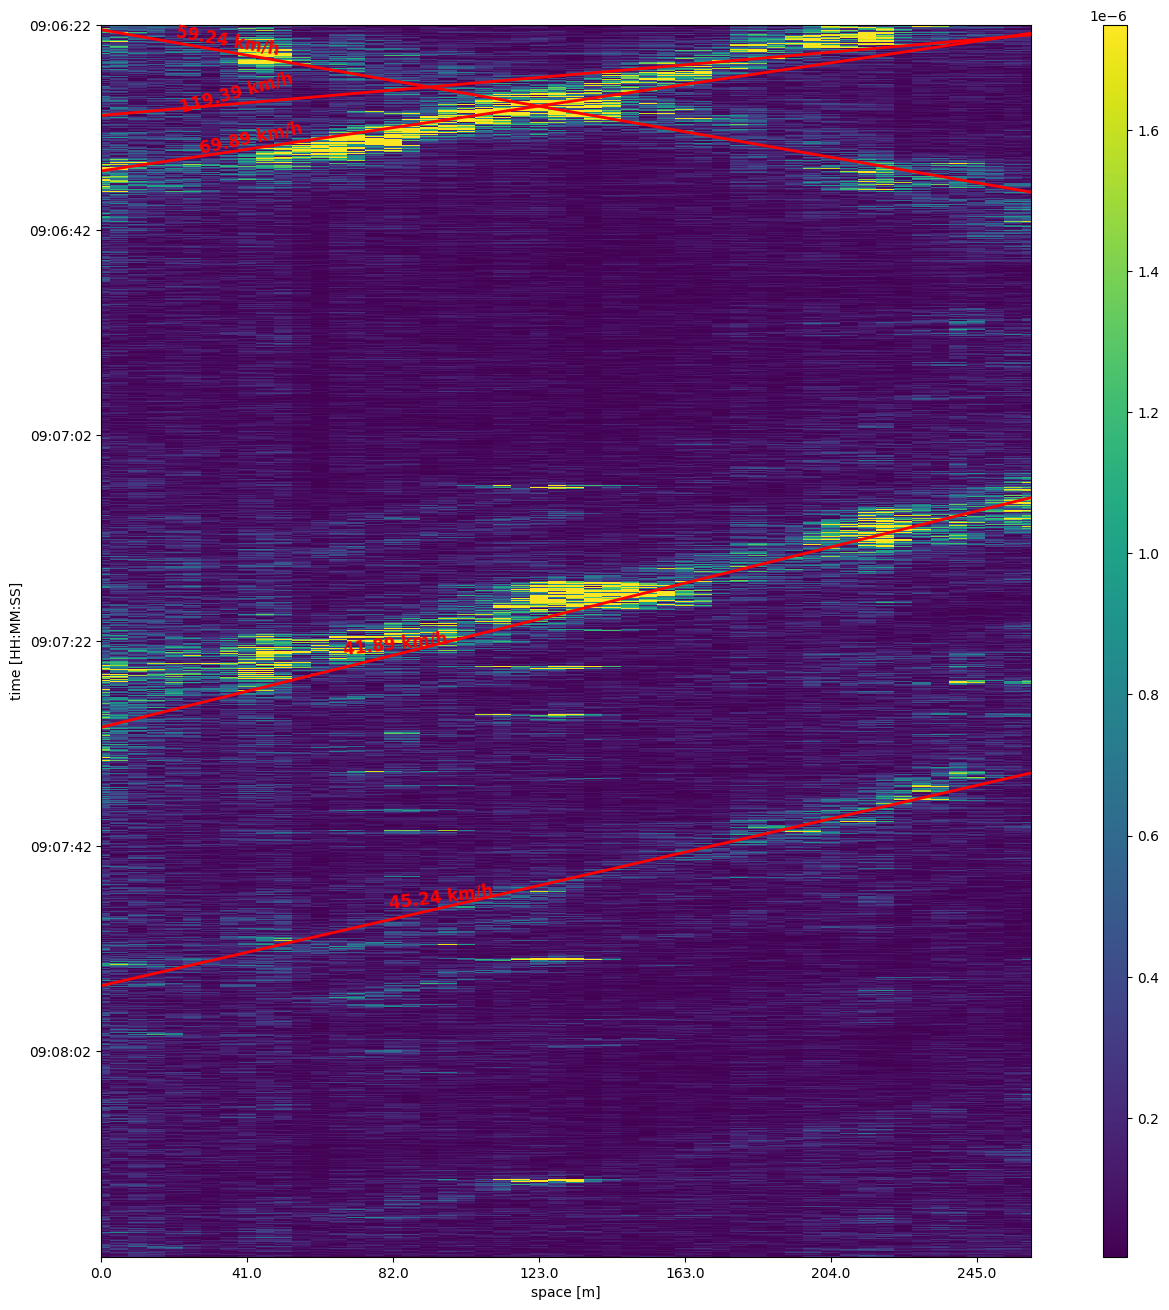

In [60]:
for times_frame in [('093122', '093312'), ('090622', '090812')]:
    data, first_file = get_time_interval(files, times_frame[0], times_frame[1])
    df = get_proper_df(data, first_file)

    low, high = np.percentile(df, [3, 99]) 
    norm_mm = Normalize(vmin=low, vmax=high, clip=True)
    norm_mm_data = norm_mm(abs(data))

    standardized_data = (abs(data) - np.mean(abs(data))) / np.std(abs(data))

    threshold = np.percentile(standardized_data, [86])
    binarized_img = norm_mm_data > threshold

    downsampled_img = downsample_vertical(binarized_img, factor=100)
    resized_img = expand_horizontal(downsampled_img, factor=11)
    scaled_img = scale_to_255(resized_img)

    lines = detect_lines(scaled_img, 420)
    pad_lines = detect_lines_close_boundaries(scaled_img, 0.15, 500)
    all_lines = lines+pad_lines
    sorted_lines = sorted(all_lines, key=lambda x: -x[0])
    true_lines = filter_lines(sorted_lines, 25)

    display_detected_movements(df, true_lines, ver_scale, hor_scale)

# **4. Algorithm - flow chart** #

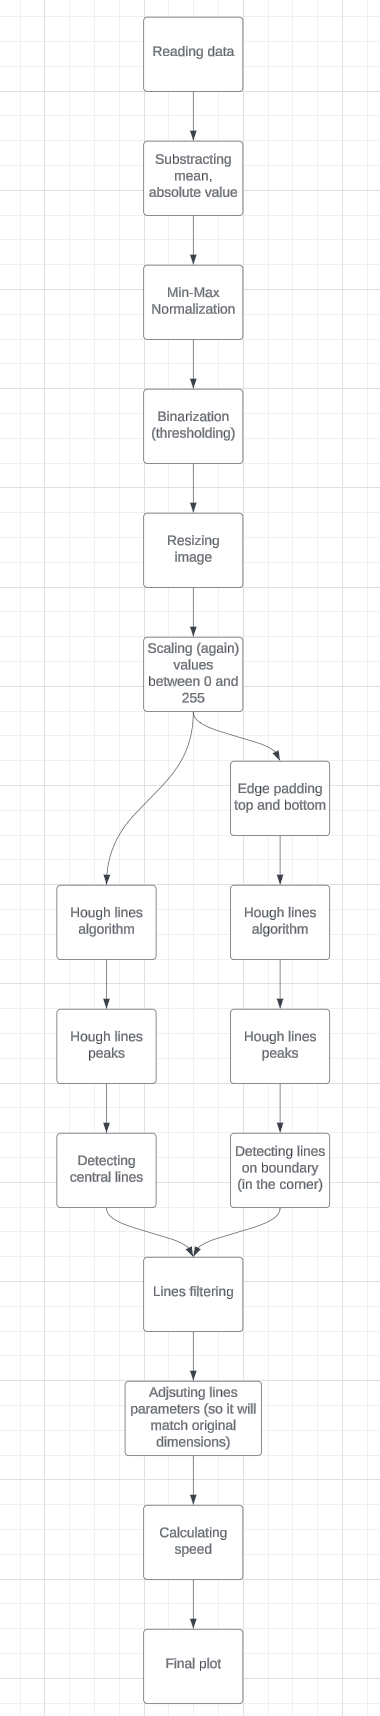

In [2]:
Image("./algorithm_flow_chart.png")

# **5. Final conclusions**

We decided to use the Straight Line Hough Transform algorithm for our project, recognizing both its advantages and limitations. After testing a variety of preprocessing techniques—including morphological operations, blurring, high-pass filters etc — we found that simplicity was key. The preprocessing involved normalizing the DataFrame using two approaches: standardization and min-max scaling. We then adjusted the threshold percentile and performed binarization. The image was scaled appropriately to ensure compatibility with the Hough Transform algorithm.

The hough_line_peaks function from the OpenCV library was instrumental in identifying line peaks in distinct regions. Instead of relying on extensive image preprocessing, we focused on filtering detected lines based on their slope (ensuring slopes were neither too steep nor too flat to represent realistic vehicle movements) and their accumulator value, which reflects the strength of the line (i.e., the number of non-zero pixels along it). Additionally, we implemented a custom filter to remove duplicate detections for wider lines, enhancing the algorithm’s accuracy.

The results were promising: the algorithm successfully detected the majority of movements, with an extremely low number of false positives (usually 1 or 2). However, the primary drawback of this approach is its inability to reliably detect shorter lines unless they are very close to the image boundaries. This limitation stems from the inherent properties of the Hough Transform, specifically the accumulator value, which is naturally lower for shorter lines. Although we explored mitigating this bias by calculating the ratio of line length to accumulator value for all detected lines, this approach proved computationally expensive and inefficient.

In conclusion, while the algorithm performs effectively for most cases, improving its sensitivity to shorter lines remains a challenge for future work.